In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [36]:
stack_fixed = 'RV4_67hrs'
# stack_moving = 'RV14_65hrs'
# stack_moving = 'RV13_64hrs'
stack_moving = 'RV19_61hrs'

# stack_moving = 'atlasV5'

In [37]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [38]:
# registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
# registration_settings

In [39]:
alignment_name_dict=dict(stack_m=stack_moving, 
                              stack_f=stack_fixed,
                              warp_setting=warp_setting,
                          vol_type_f='annotationAsScore',
                          vol_type_m='annotationAsScore')

In [40]:
def generate_aligner_parameters(warp_setting, alignment_name_dict):
    """
    Args:
        warp_setting (int):
        alignment_name_dict (dict):
        
    Returns:
        - 'volume_moving': dict {ind_m: 3d array},
        - 'volume_fixed': dict {ind_m: 3d array},
        - 'structure_to_label_moving': dict {str: int},
        - 'label_to_structure_moving': dict {int: str},
        - 'structure_to_label_fixed': dict {str: int}, 
        - 'label_to_structure_fixed': dict {int: str},
        - 'label_weights_m': dict {int: float},
        - 'label_mapping_m2f': dict {int: int},
    """
    
    stack_m = alignment_name_dict['stack_m']
    stack_f = alignment_name_dict['stack_f']
    warp_setting = alignment_name_dict['warp_setting']
    vol_type_f = alignment_name_dict['vol_type_f']
    vol_type_m = alignment_name_dict['vol_type_m']
    
    registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
    warp_properties = registration_settings.loc[warp_setting]
    print warp_properties

    ################################################################
    
    upstream_warp_setting = warp_properties['upstream_warp_id']
    if upstream_warp_setting == 'None':
        upstream_warp_setting = None
    transform_type = warp_properties['transform_type']
#     terminate_thresh = warp_properties['terminate_thresh']
    grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
#     grid_search_sample_number = warp_properties['grid_search_sample_number']
#     std_tx_um = warp_properties['std_tx_um']
#     std_ty_um = warp_properties['std_ty_um']
#     std_tz_um = warp_properties['std_tz_um']
#     std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
#     print std_tx, std_ty, std_tz, std_theta_xy

    surround_weight = warp_properties['surround_weight']
    if isinstance(surround_weight, float) or isinstance(surround_weight, int):
        surround_weight = float(surround_weight)
        include_surround = surround_weight != 0 and not np.isnan(surround_weight)
    elif isinstance(surround_weight, str):
        surround_weight = str(surround_weight)
        # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
        include_surround = True

    print surround_weight, include_surround

#     MAX_ITER_NUM = 1000
#     HISTORY_LEN = 20
#     lr1 = 10
#     lr2 = 0.1
    
    positive_weight = 'size'
    # positive_weight = 'inverse'
    
    ############################################################################
    
    volume_moving, volume_moving_bbox, structure_to_label_moving, label_to_structure_moving = \
    DataManager.load_original_volume_all_known_structures_v2(stack=stack_m, sided=True, 
                                                          volume_type=vol_type_m, 
                                                          include_surround=include_surround,
                                                         structures=['Sp5I_L', 'Sp5I_R',
                                                                     'LRt_L', 'LRt_R',
                                                                     '7N_L', '7N_R', 
                                                                     'Sp5C_L', 'Sp5C_R',
                                                                     '5N_L', '5N_R', 
                                                                     '7n_L', '7n_R', 
                                                                     'Sp5O_L', 'Sp5O_R',
                                                                     'Amb_L', 'Amb_R'],
                                                            return_label_mappings=True, 
                                                             name_or_index_as_key='index',
                                                             common_shape=True)
    if len(volume_moving) == 0:
        sys.stderr.write("No moving volumes.\n")
    else:
        sys.stderr.write("Loaded moving volumes: %s.\n" % sorted(structure_to_label_moving.keys()))
    
    #############################################################################
    
    volume_fixed, volume_fixed_bbox, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_original_volume_all_known_structures_v2(stack=stack_f, sided=True, 
                                                          volume_type=vol_type_f,
                                                         include_surround=include_surround,
                                                         structures=['Sp5I_L', 'Sp5I_R',
                                                                     'LRt_L', 'LRt_R',
                                                                     '7N_L', '7N_R', 
                                                                     'Sp5C_L', 'Sp5C_R',
                                                                     '5N_L', '5N_R', 
                                                                     '7n_L', '7n_R', 
                                                                     'Sp5O_L', 'Sp5O_R',
                                                                    'Amb_L', 'Amb_R'],
                                                         return_label_mappings=True, 
                                                             name_or_index_as_key='index',
                                                         common_shape=True)
    if len(volume_fixed) == 0:
        sys.stderr.write("No fixed volumes.\n")
    else:
        sys.stderr.write("Loaded fixed volumes: %s.\n" % sorted(structure_to_label_fixed.keys()))
            
    ############################################################################
    
    structure_subset = all_known_structures_sided

    if include_surround:
        structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]
    
    label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}
    
    t = time.time()
    cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
#     pool = Pool(NUM_CORES)
#     volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
#                                              pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
#                                                       volume_moving.keys())))
#     pool.close()
#     pool.join()
    volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                             map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                      volume_moving.keys())))
    sys.stderr.write("Computing structure sizes: %.2f s\n" % (time.time() - t))
    
    label_weights_m = {}

    for label_m in label_mapping_m2f.iterkeys():
        name_m = label_to_structure_moving[label_m]
        if not is_surround_label(name_m):
            if positive_weight == 'size':
                label_weights_m[label_m] = 1.
            elif positive_weight == 'inverse':
                p = np.percentile(volume_moving_structure_sizes.values(), 50)
                label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
            else:
                sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)

    for label_m in label_mapping_m2f.iterkeys():
        name_m = label_to_structure_moving[label_m]
        if is_surround_label(name_m):
            label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
            if surround_weight == 'inverse':
    #             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
                label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
                label_weights_m[label_m] = surround_weight
            else:
                sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)
                
    ######################################################
    
    alinger_parameters = \
    {'label_weights_m': label_weights_m,
     'label_mapping_m2f': label_mapping_m2f,
     'volume_moving': volume_moving,
     'volume_fixed': volume_fixed,
     'structure_to_label_moving': structure_to_label_moving,
     'label_to_structure_moving': label_to_structure_moving,
     'structure_to_label_fixed': structure_to_label_fixed, 
     'label_to_structure_fixed': label_to_structure_fixed,
     'transform_type': transform_type,
     'grad_computation_sample_number': grad_computation_sample_number,
     'volume_moving_bbox': volume_moving_bbox,
     'volume_fixed_bbox': volume_fixed_bbox
    }
                
    return alinger_parameters

In [41]:
aligner_parameters = generate_aligner_parameters(warp_setting=warp_setting, 
                                                 alignment_name_dict=alignment_name_dict)

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

Prior structure/index map not found. Generating a new one.


aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_L.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'
Score volume for Sp5I_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_R.bp"
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_dow

rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5C_R_bbox.txt" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5C_R_bbox.txt" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5C_R_bbox.txt"
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19

File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'
Score volume for Sp5O_L does not exist.



rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_R.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Sp5O_R.bp'
Score volume for Sp5O_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L.bp"
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_bbox.txt" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_

File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_R.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.
Loaded moving volumes: ['5N_L', '5N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'Amb_L', 'LRt_L', 'LRt_R', 'Sp5C_L', 'Sp5C_R', 'Sp5I_R'].
Prior structure/index map not found. Generating a new one.



rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.
Loaded fixed volumes: ['5N_L', '5N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'LRt_L', 'LRt_R', 'Sp5C_L', 'Sp5C_R', 'Sp5I_L', 'Sp5I_R', 'Sp5O_L', 'Sp5O_R'].
Computing structure sizes: 3.84 s


In [42]:
volume_fixed = aligner_parameters['volume_fixed']
volume_moving = aligner_parameters['volume_moving']

In [12]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=aligner_parameters['label_mapping_m2f'])

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [13]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[aligner_parameters['structure_to_label_moving']['7N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [ 164.55561562  144.46717703   76.48517818], centroid_f: [ 182.9970302   174.35975548   90.48145744]


In [14]:
aligner.set_label_weights(label_weights=aligner_parameters['label_weights_m'])

In [37]:
# gradient_filepath_map_f = \
# {ind_f: DataManager.get_volume_gradient_filepath_template(\
#                                                           stack=stack_fixed, 
#                                                           structure=label_to_structure_fixed[ind_f],
#                                                          volume_type='annotationAsScore')
#  for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [38]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

In [15]:
def compute_gradient(volumes, smooth_first=False):
    """
    Args:
        volumes (dict {int: 3d-array})
        smooth_first (bool): If true, smooth each volume before computing gradients. 
        This is useful if volume is binary and gradients are only nonzero at structure borders.
        
    Note:
        # 3.3 second - re-computing is much faster than loading
        # .astype(np.float32) is important;
        # Otherwise the score volume is type np.float16, np.gradient requires np.float32 and will have to convert which is very slow
        # 2s (float32) vs. 20s (float16)
    """
    gradients = {}
    for ind, v in volumes.iteritems():
        if smooth_first:
            gy_gx_gz = np.gradient(gaussian(v, 3).astype(np.float32), 3, 3, 3)
        else:
            gy_gx_gz = np.gradient(v.astype(np.float32), 3, 3, 3)
        gradients[ind] = np.array([gy_gx_gz[1], gy_gx_gz[0], gy_gx_gz[2]])
    return gradients

In [16]:
gradients_f = compute_gradient(volume_fixed, smooth_first=True)

In [17]:
# gradients_f = {}
# for ind_f, v in volume_fixed.iteritems():
#     gy_gx_gz = np.gradient(gaussian(v, 3).astype(np.float32), 3, 3, 3)
#     # 3.3 second - re-computing is much faster than loading
#     # .astype(np.float32) is important;
#     # Otherwise the score volume is type np.float16, np.gradient requires np.float32 and will have to convert which is very slow
#     # 2s (float32) vs. 20s (float16)
#     gradients_f[ind_f] = np.array([gy_gx_gz[1], gy_gx_gz[0], gy_gx_gz[2]])
#     del gy_gx_gz

In [18]:
aligner.load_gradient(gradients=gradients_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14])


In [19]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=aligner_parameters['transform_type'], 
                                     max_iter_num=300,
                                     history_len=20, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=aligner_parameters['grad_computation_sample_number'],
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Norm of gradient = 3.464102
in T: 0.00 0.00 0.00, out T: 1.00 -1.00 -1.00
step: 8.78 seconds
current score: -2.857477
new_T: [ 1. -1. -1.]
det: 1.10

iteration 1
Norm of gradient = 1.800493
in T: 1.00 -1.00 -1.00, out T: 0.56 -0.65 -0.57
step: 3.61 seconds
current score: -2.883111
new_T: [ 0.56317172 -0.65031662 -0.57252879]
det: 1.11

iteration 2
Norm of gradient = 1.406188
in T: 0.56 -0.65 -0.57, out T: 0.39 -0.60 0.25
step: 0.88 seconds
current score: -2.843987
new_T: [ 0.39398992 -0.5964067   0.25004677]
det: 1.19

iteration 3
Norm of gradient = 1.543015
in T: 0.39 -0.60 0.25, out T: 0.67 -0.66 -0.42
step: 0.44 seconds
current score: -2.874305
new_T: [ 0.66857656 -0.66457335 -0.4249531 ]
det: 1.09

iteration 4
Norm of gradient = 1.224937
in T: 0.67 -0.66 -0.42, out T: 0.33 -0.74 -0.32
step: 0.48 seconds
current score: -2.846509
new_T: [ 0.33365154 -0.73558239 -0.3204616 ]
det: 1.14

iteration 5
Norm of gradient = 1.102575
in T: 0.33 -0.74 -0.32, out T: 0.64 -0.46 -0.31

Norm of gradient = 0.294688
in T: -0.43 -1.18 0.56, out T: -0.51 -1.10 0.48
step: 0.25 seconds
current score: -2.841937
new_T: [-0.51473535 -1.09899112  0.48318829]
det: 1.10

iteration 45
Norm of gradient = 0.321179
in T: -0.51 -1.10 0.48, out T: -0.45 -1.21 0.60
step: 0.26 seconds
current score: -2.840186
new_T: [-0.44519427 -1.21367665  0.59552105]
det: 1.12

iteration 46
Norm of gradient = 0.316214
in T: -0.45 -1.21 0.60, out T: -0.55 -1.13 0.52
step: 0.24 seconds
current score: -2.842237
new_T: [-0.55325387 -1.12813434  0.52289656]
det: 1.09

iteration 47
Norm of gradient = 0.318334
in T: -0.55 -1.13 0.52, out T: -0.48 -1.25 0.63
step: 0.25 seconds
current score: -2.839955
new_T: [-0.47646985 -1.245802    0.62685807]
det: 1.12

iteration 48
Norm of gradient = 0.307935
in T: -0.48 -1.25 0.63, out T: -0.59 -1.16 0.56
step: 0.25 seconds
current score: -2.841933
new_T: [-0.58522354 -1.16283026  0.55822486]
det: 1.09

iteration 49
Norm of gradient = 0.307843
in T: -0.59 -1.16 0.56, out

Norm of gradient = 0.110615
in T: -0.97 -1.67 1.26, out T: -1.00 -1.65 1.24
step: 0.24 seconds
current score: -2.840052
new_T: [-1.00244199 -1.65274048  1.23580199]
det: 1.10

iteration 89
Norm of gradient = 0.115424
in T: -1.00 -1.65 1.24, out T: -0.99 -1.69 1.29
step: 0.24 seconds
current score: -2.839735
new_T: [-0.98925804 -1.69383643  1.28719845]
det: 1.11

iteration 90
Norm of gradient = 0.107985
in T: -0.99 -1.69 1.29, out T: -1.01 -1.66 1.27
step: 0.24 seconds
current score: -2.840434
new_T: [-1.00583025 -1.66347821  1.26839156]
det: 1.10

iteration 91
Norm of gradient = 0.141239
in T: -1.01 -1.66 1.27, out T: -1.00 -1.72 1.32
step: 0.25 seconds
current score: -2.839863
new_T: [-0.99652545 -1.72057023  1.32493327]
det: 1.11

iteration 92
Norm of gradient = 0.142008
in T: -1.00 -1.72 1.32, out T: -1.03 -1.69 1.29
step: 0.25 seconds
current score: -2.840239
new_T: [-1.02803124 -1.68530811  1.29062106]
det: 1.09

iteration 93
Norm of gradient = 0.152437
in T: -1.03 -1.69 1.29, out

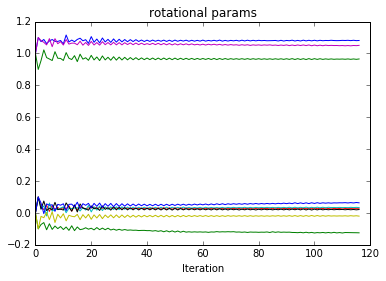

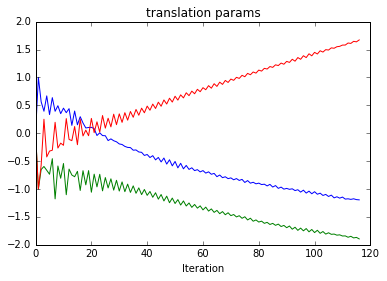

Best trial: 0
-2.83915699034 -2.83960299095
[[ 1.07839225 -0.12188375  0.02611964 -1.05547948]
 [ 0.0352589   1.04989558 -0.01671958 -1.70082274]
 [ 0.01893135  0.06302119  0.96250385  1.32458434]]


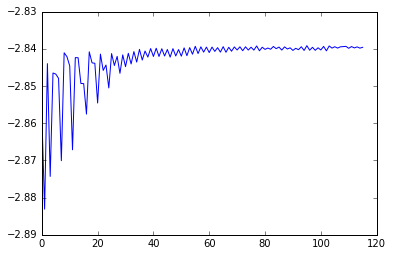

In [21]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [22]:
crop_origin_m = aligner_parameters['volume_moving_bbox'][[0,2,4]]
print crop_origin_m

crop_origin_f = aligner_parameters['volume_fixed_bbox'][[0,2,4]]
print crop_origin_f

[-706 -406    0]
[1149  492  -19]


In [ ]:
save_alignment_results(T_all_trials[best_trial], 
                       aligner.centroid_m, aligner.centroid_f, 
                       crop_origin_m, crop_origin_f,
                       score_traj=scores_all_trials[best_trial],
                       parameter_traj=traj_all_trials[best_trial],
                      alignment_name_dict=alignment_name_dict)

# Convert parameters

In [43]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)



# If parameters are generated by the above code and not yet saved.

# global_params, global_centroid_m, global_centroid_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f)

# G_movingvol2fixedvol = consolidate(params=global_params, 
#                                    centroid_m=global_centroid_m, 
#                                    centroid_f=global_centroid_f)
# print G_movingvol2fixedvol

# for ind_m, v in volume_moving.iteritems():
    
#     structure = aligner_parameters['label_to_structure_moving'][ind_m]
#     transform_and_save_volume(v, structure, G_movingvol2fixedvol[:3], 
#                               crop_origin_f=crop_origin_f,
#                               alignment_name_dict=alignment_name_dict)



# If parameters are already saved.
tf_parameter_dict = DataManager.load_alignment_parameters_v2(stack_f=stack_fixed, stack_m=stack_moving, warp_setting=24, 
                                         vol_type_f='annotationAsScore', vol_type_m='annotationAsScore',
                                         downscale=32)
cf = np.array(tf_parameter_dict['centroid_f'])
cm = np.array(tf_parameter_dict['centroid_m'])
of = np.array(tf_parameter_dict['crop_origin_f'])
om = np.array(tf_parameter_dict['crop_origin_m'])
params = np.array(tf_parameter_dict['params'])
Rt = np.reshape(params, (3,4))
R = Rt[:3,:3]
t = Rt[:3,3]

G_movingvol2fixedvol = consolidate(params=params, 
                                   centroid_m=cm, 
                                   centroid_f=cf)

for ind_m, v in volume_moving.iteritems():    
    structure = aligner_parameters['label_to_structure_moving'][ind_m]
    transform_and_save_volume(v, structure, G_movingvol2fixedvol[:3], 
                              crop_origin_f=of,
                              alignment_name_dict=alignment_name_dict)

Interpolating/filling sparse volume: 0.01 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24

Transform: 2.55 seconds.


# Visualize global

In [43]:
structure = 'Sp5C_L'

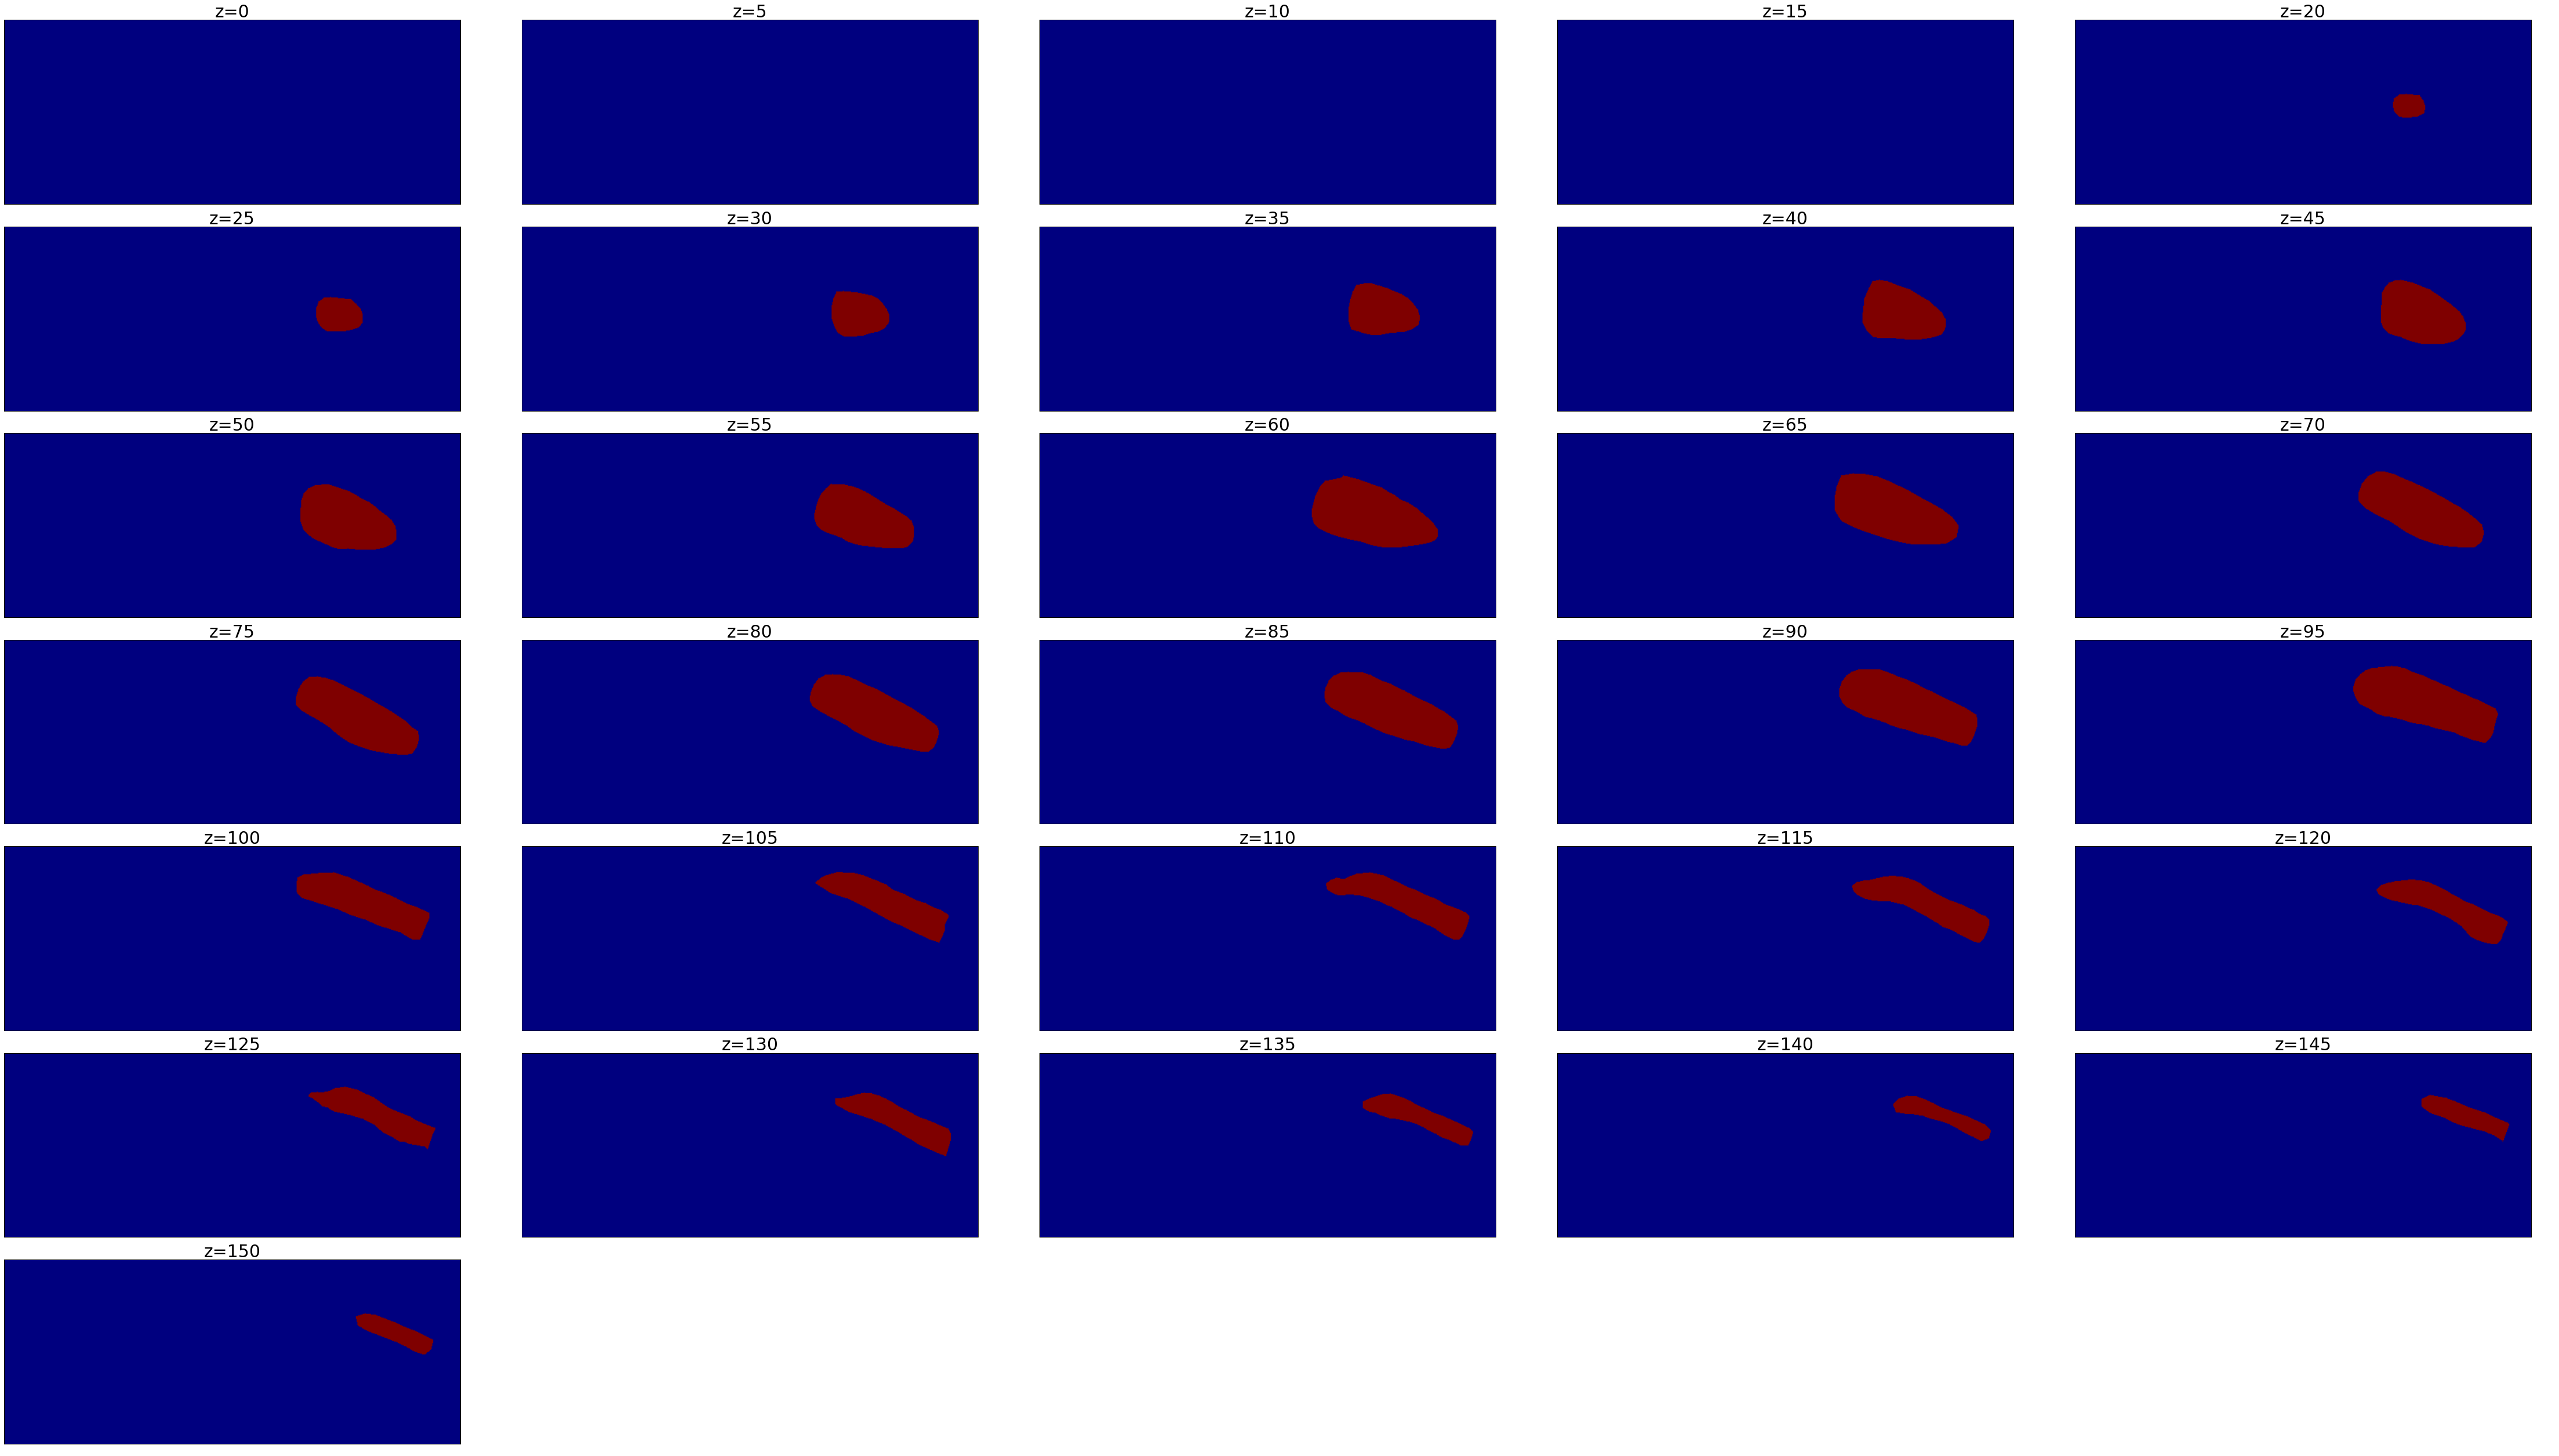

In [44]:
display_volume_sections(volume_fixed[aligner_parameters['structure_to_label_fixed'][structure]], start_level=0)

In [45]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[aligner_parameters['structure_to_label_moving'][structure]]

# volume_m2fg_in_bboyou can sxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
# transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

Interpolating/filling sparse volume: 0.04 seconds.


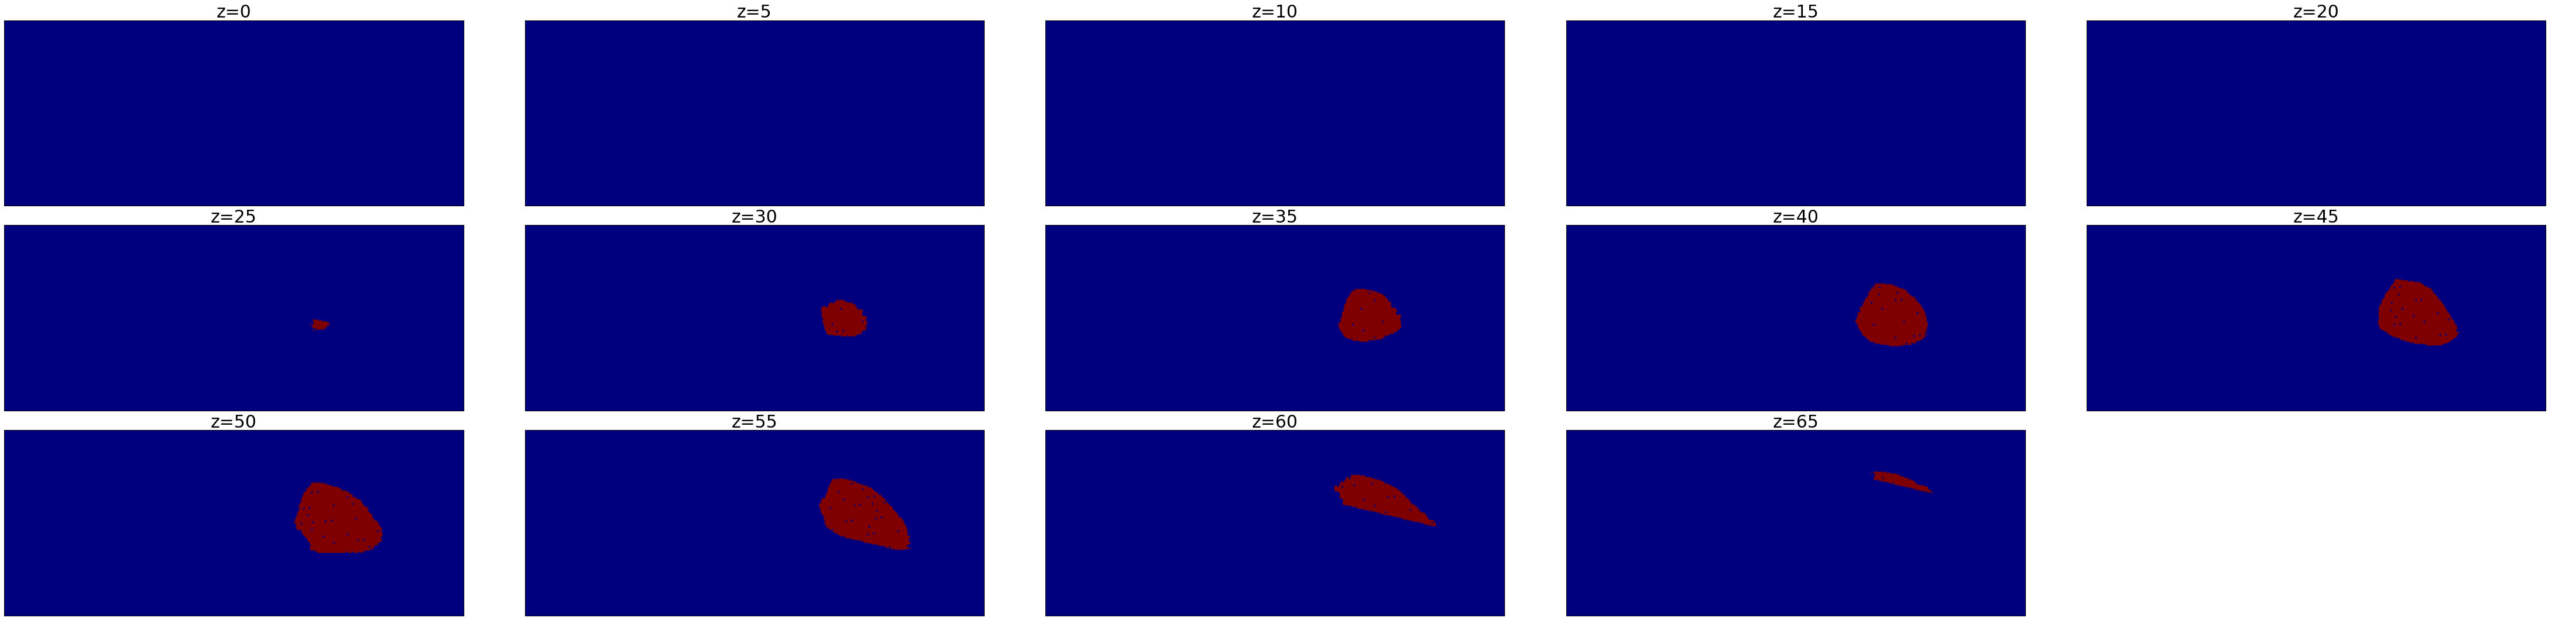

In [48]:
ydim_f, xdim_f, zdim_f = volume_fixed[aligner_parameters['structure_to_label_fixed'][structure]].shape

v_m2fg = \
crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2fg, start_level=0)

In [49]:
# Warping all structures.

volume_m2fg = {}
for label_m, vol_m in volume_moving.iteritems():
    
#     volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
#         transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

    volume_m2fg[label_m] = crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.03 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.22 seconds.
Interpolating/filling sparse volume: 0.13 seconds.
Interpolating/filling sparse volume: 0.10 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.05 seconds.
Interpolating/filling sparse volume: 0.12 seconds.


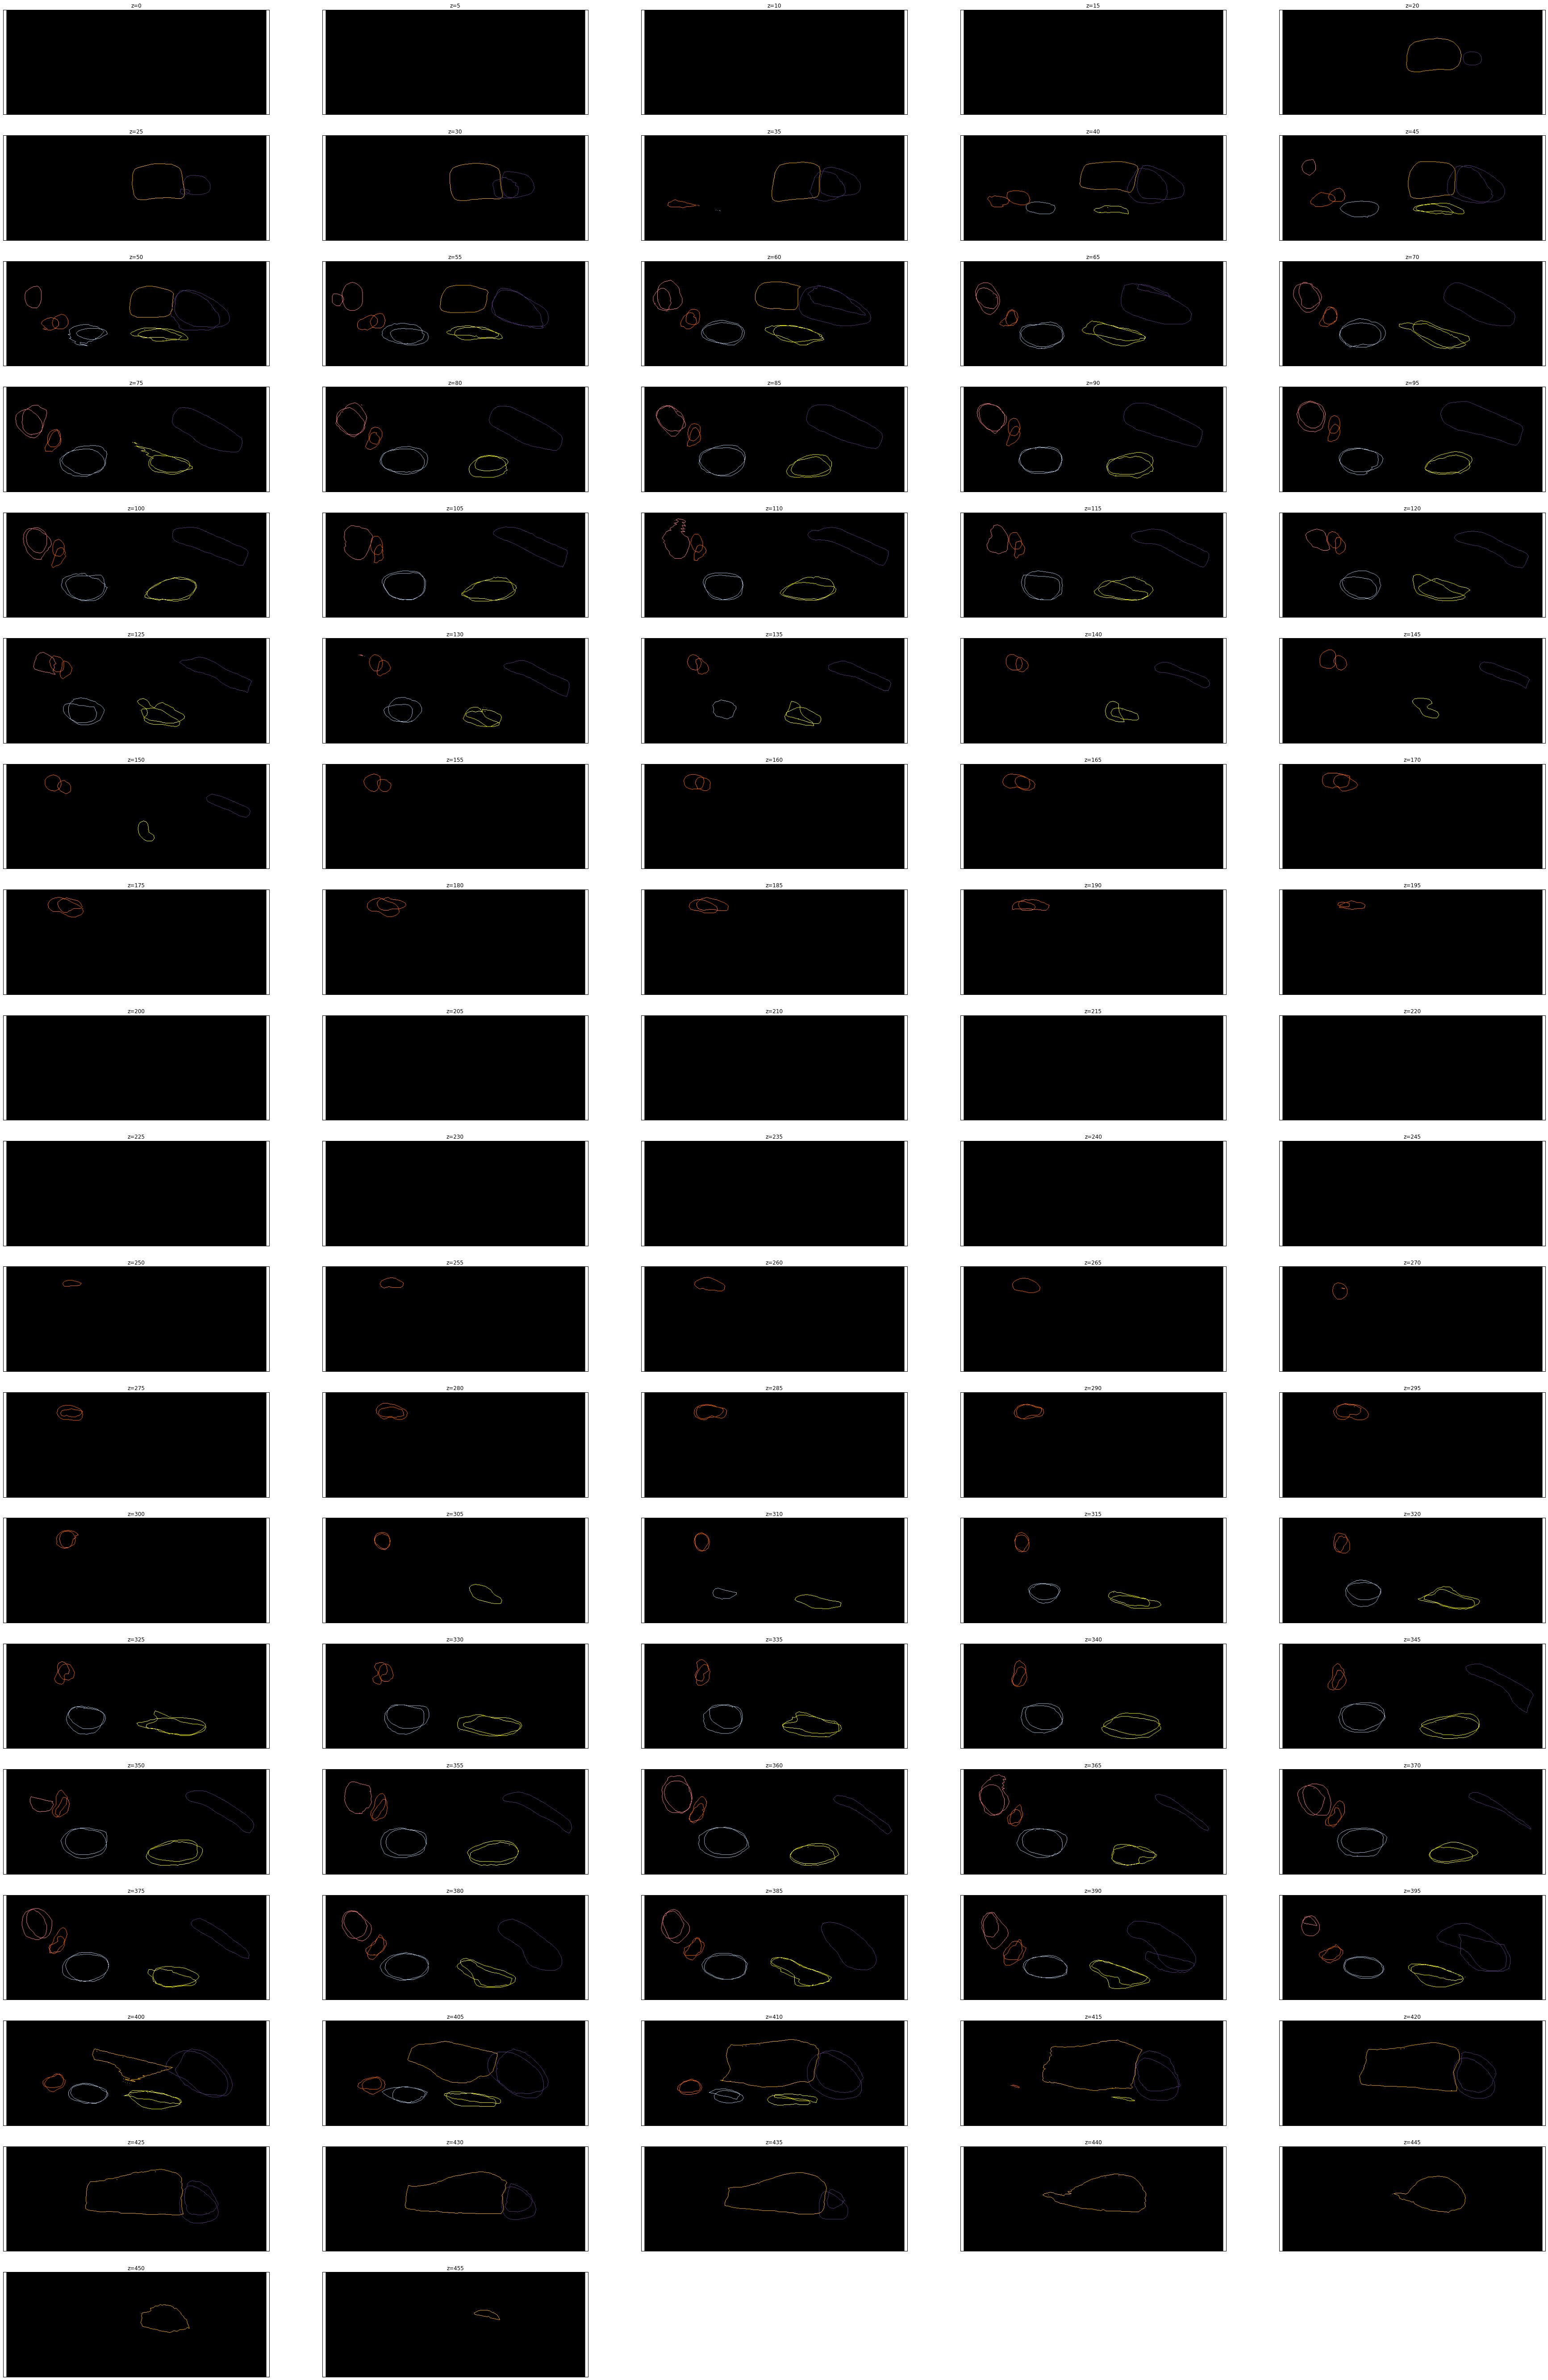

In [52]:
structures_to_draw = [l for l in volume_m2fg.keys() if not is_surround_label(aligner_parameters['label_to_structure_moving'][l])]

colors = {l: name_unsided_to_color[convert_to_original_name(aligner_parameters['label_to_structure_fixed'][l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fg, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
#               markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

# Local

In [57]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000,1000,2000,2000,2000,30,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000,10000,100,100,100,30,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000,10000,100,100,100,10,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000,10000,100,100,100,30,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000,10000,100,100,100,30,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000,1000,50,50,50,10,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000,10000,200,200,200,30,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000,10000,2000,2000,2000,30,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000,1000,100,100,100,30,0,NaN,NaN,NaN


In [58]:
warp_setting = 25

In [59]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                                                 24
transform_type                                                                rigid
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                       NaN
std_ty_um                                                                       NaN
std_tz_um                                                                       NaN
std_theta_xy_degree                                                             NaN
surround_weight                                                             inverse
regularization_weight                                                             0
comment                           local reg with surr no grid search; global

In [60]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
lr1 = 10
lr2 = 0.1

In [70]:
structure = 'Sp5I_R'

In [71]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.


rm -rf "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"


Volume shape: (246, 609, 459)


In [72]:
volume_fixed = {ind_f: gaussian(v, 3) for ind_f, v in volume_fixed.iteritems()}

In [73]:
# if include_surround:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                 structures=[structure, convert_to_surround_name(structure, margin='200')])
# else:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                                                  structures=[structure])

if include_surround:
    structures = [structure, convert_to_surround_name(structure, margin='200')]
else:
    structures = [structure]
    
volume_moving_in_bboxrel2fixedvol, volume_moving_bbox_rel2fixedvol, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_transformed_volume_all_known_structures_v2(stack_m=stack_moving, 
                                                         stack_f=stack_fixed,
                                                         warp_setting=24,
                                                         vol_type_f='annotationAsScore',
                                                         vol_type_m='annotationAsScore',
                            structures=[structure, convert_to_surround_name(structure, margin='200')],
                                                        return_label_mappings=True,
                                                         name_or_index_as_key='index',                                                               
                                                            common_shape=True)

print volume_moving_bbox_rel2fixedvol

Prior structure/index map not found. Generating a new one.


rm -rf "/home/yuncong/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/home/yuncong/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/home/yuncong/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"
[ 264.  435.   84.  183.  408.  438.]


File does not exist: /home/yuncong/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp
[Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp'
Score volume for Sp5I_R_surround_200 does not exist.


In [74]:
# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving_in_bboxrel2fixedvol.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving_in_bboxrel2fixedvol[l] > cutoff), 
                                                  volume_moving_in_bboxrel2fixedvol.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [75]:
label_weights_m

{1: 1.0}

In [76]:
aligner = Aligner4(volume_fixed, volume_moving_in_bboxrel2fixedvol, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 84.27557004  48.15351969  13.80465055], centroid_f: [ 340.23200185  125.98403353  423.95310448]


In [79]:
gradients_f = {}

for ind_f, v in volume_fixed.iteritems():
    gy_gx_gz = np.gradient(v.astype(np.float32), 3, 3, 3)
    # 3.3 second - re-computing is much faster than loading
    # .astype(np.float32) is important;
    # Otherwise the score volume is type np.float16, np.gradient requires np.float32 and will have to convert which is very slow
    # 2s (float32) vs. 20s (float16)
    gradients_f[ind_f] = np.array([gy_gx_gz[1], gy_gx_gz[0], gy_gx_gz[2]])

In [81]:
aligner.load_gradient(gradients=gradients_f) # 120s = 2 mins

indices_f: set([1])


In [82]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
Norm of gradient = 2.449490
around x=-0.58; around y=-0.57; around z=0.58
step: 0.10 seconds
current score: 0.152679
new_T: [ 0.98996692  1.00996642  0.99993333]
det: 1.00

iteration 1
Norm of gradient = 1.324483
around x=-0.96; around y=-0.34; around z=0.94
step: 0.07 seconds
current score: 0.153495
new_T: [ 0.93030693  1.62972998  0.41066146]
det: 1.00

iteration 2
Norm of gradient = 1.411958
around x=-1.10; around y=-0.82; around z=1.19
step: 0.07 seconds
current score: 0.153112
new_T: [ 0.46451787  2.05396765  1.21292011]
det: 1.00

iteration 3
Norm of gradient = 1.094646
around x=-1.35; around y=-0.53; around z=1.42
step: 0.07 seconds
current score: 0.153280
new_T: [ 0.82689596  2.44114562  0.65203795]
det: 1.00

iteration 4
Norm of gradient = 0.753297
around x=-1.41; around y=-0.79; around z=1.58
step: 0.07 seconds
current score: 0.153118
new_T: [ 0.6389098   2.72084551  1.0567159 ]
det: 1.00

iteration 5
Norm of gradient = 0.454643
around x=-1.53; around y=-0.73; ar

Norm of gradient = 0.121673
around x=1.04; around y=-1.18; around z=2.37
step: 0.07 seconds
current score: 0.156649
new_T: [ 0.10919883  4.04255068  1.04130519]
det: 1.00

iteration 46
Norm of gradient = 0.122705
around x=1.10; around y=-1.18; around z=2.37
step: 0.06 seconds
current score: 0.156694
new_T: [ 0.04978833  4.0301527   1.03632252]
det: 1.00

iteration 47
Norm of gradient = 0.117749
around x=1.16; around y=-1.18; around z=2.36
step: 0.07 seconds
current score: 0.156739
new_T: [  2.95974798e-05   4.01709023e+00   1.03277860e+00]
det: 1.00

iteration 48
Norm of gradient = 0.115212
around x=1.22; around y=-1.18; around z=2.35
step: 0.09 seconds
current score: 0.156790
new_T: [-0.0461041   4.00370326  1.02969029]
det: 1.00

iteration 49
Norm of gradient = 0.111347
around x=1.28; around y=-1.18; around z=2.35
step: 0.07 seconds
current score: 0.156829
new_T: [-0.08477738  3.98968474  1.02194355]
det: 1.00

iteration 50
Norm of gradient = 0.106255
around x=1.33; around y=-1.19; a

Norm of gradient = 0.058131
around x=3.08; around y=-1.19; around z=2.13
step: 0.07 seconds
current score: 0.158140
new_T: [-0.41185763  3.565674    0.99165164]
det: 1.00

iteration 93
Norm of gradient = 0.060420
around x=3.11; around y=-1.19; around z=2.12
step: 0.07 seconds
current score: 0.158160
new_T: [-0.43346363  3.55594023  0.99115538]
det: 1.00

iteration 94
Norm of gradient = 0.056447
around x=3.14; around y=-1.19; around z=2.12
step: 0.07 seconds
current score: 0.158176
new_T: [-0.44116563  3.54618131  0.98999246]
det: 1.00

iteration 95
Norm of gradient = 0.056486
around x=3.17; around y=-1.19; around z=2.11
step: 0.07 seconds
current score: 0.158190
new_T: [-0.43054212  3.53651699  0.98987968]
det: 1.00

iteration 96
Norm of gradient = 0.056815
around x=3.20; around y=-1.19; around z=2.11
step: 0.07 seconds
current score: 0.158204
new_T: [-0.44552827  3.52710055  0.99157993]
det: 1.00

iteration 97
Norm of gradient = 0.053844
around x=3.23; around y=-1.19; around z=2.11
st

Norm of gradient = 0.034883
around x=4.22; around y=-1.19; around z=1.96
step: 0.07 seconds
current score: 0.158627
new_T: [-0.55110053  3.23523388  1.009125  ]
det: 1.00

iteration 140
Norm of gradient = 0.034506
around x=4.24; around y=-1.19; around z=1.96
step: 0.07 seconds
current score: 0.158639
new_T: [-0.54999483  3.22870973  1.00968619]
det: 1.00

iteration 141
Norm of gradient = 0.034780
around x=4.26; around y=-1.19; around z=1.96
step: 0.07 seconds
current score: 0.158644
new_T: [-0.55780384  3.2223253   1.00929145]
det: 1.00

iteration 142
Norm of gradient = 0.033873
around x=4.28; around y=-1.19; around z=1.96
step: 0.08 seconds
current score: 0.158650
new_T: [-0.55596681  3.21584114  1.00911866]
det: 1.00

iteration 143
Norm of gradient = 0.034339
around x=4.30; around y=-1.19; around z=1.95
step: 0.07 seconds
current score: 0.158656
new_T: [-0.5641414   3.20947516  1.00878036]
det: 1.00

iteration 144
Norm of gradient = 0.033454
around x=4.32; around y=-1.19; around z=1.

step: 0.06 seconds
current score: 0.158823
new_T: [-0.72110413  2.95614848  1.01609834]
det: 1.00

iteration 186
Norm of gradient = 0.023350
around x=4.97; around y=-1.22; around z=1.82
step: 0.07 seconds
current score: 0.158825
new_T: [-0.71926295  2.95141996  1.01640375]
det: 1.00

iteration 187
Norm of gradient = 0.023216
around x=4.98; around y=-1.22; around z=1.82
step: 0.07 seconds
current score: 0.158826
new_T: [-0.72134404  2.94678769  1.01729833]
det: 1.00

iteration 188
Norm of gradient = 0.023000
around x=5.00; around y=-1.22; around z=1.82
step: 0.07 seconds
current score: 0.158830
new_T: [-0.71916546  2.94215603  1.01765652]
det: 1.00

iteration 189
Norm of gradient = 0.022798
around x=5.01; around y=-1.22; around z=1.82
step: 0.06 seconds
current score: 0.158831
new_T: [-0.720994    2.93767717  1.01878197]
det: 1.00

iteration 190
Norm of gradient = 0.022568
around x=5.02; around y=-1.22; around z=1.82
step: 0.06 seconds
current score: 0.158835
new_T: [-0.71958383  2.9331

Norm of gradient = 0.017347
around x=5.45; around y=-1.24; around z=1.73
step: 0.07 seconds
current score: 0.158913
new_T: [-0.77791663  2.77257789  1.03587084]
det: 1.00

iteration 231
Norm of gradient = 0.016858
around x=5.46; around y=-1.24; around z=1.73
step: 0.07 seconds
current score: 0.158912
new_T: [-0.7809082  2.768944   1.0354586]
det: 1.00

iteration 232
Norm of gradient = 0.017130
around x=5.47; around y=-1.24; around z=1.73
step: 0.08 seconds
current score: 0.158915
new_T: [-0.78513522  2.76531949  1.03586006]
det: 1.00

iteration 233
Norm of gradient = 0.016855
around x=5.48; around y=-1.24; around z=1.73
step: 0.07 seconds
current score: 0.158917
new_T: [-0.78886908  2.76169293  1.03579097]
det: 1.00

iteration 234
Norm of gradient = 0.016480
around x=5.49; around y=-1.24; around z=1.73
step: 0.07 seconds
current score: 0.158918
new_T: [-0.79075024  2.7580509   1.03572452]
det: 1.00

iteration 235
Norm of gradient = 0.016673
around x=5.49; around y=-1.24; around z=1.73


Norm of gradient = 0.012898
around x=5.82; around y=-1.25; around z=1.65
step: 0.08 seconds
current score: 0.158962
new_T: [-0.88913406  2.61674353  1.03856298]
det: 1.00

iteration 277
Norm of gradient = 0.012978
around x=5.82; around y=-1.25; around z=1.65
step: 0.07 seconds
current score: 0.158963
new_T: [-0.89228901  2.61365772  1.038425  ]
det: 1.00

iteration 278
Norm of gradient = 0.012515
around x=5.83; around y=-1.25; around z=1.65
step: 0.07 seconds
current score: 0.158963
new_T: [-0.89182929  2.61062019  1.03847446]
det: 1.00

iteration 279
Norm of gradient = 0.012729
around x=5.84; around y=-1.25; around z=1.65
step: 0.07 seconds
current score: 0.158965
new_T: [-0.89418737  2.6075643   1.03879111]
det: 1.00

iteration 280
Norm of gradient = 0.012407
around x=5.84; around y=-1.25; around z=1.65
step: 0.08 seconds
current score: 0.158965
new_T: [-0.89529994  2.60454796  1.03868142]
det: 1.00

iteration 281
Norm of gradient = 0.012430
around x=5.85; around y=-1.25; around z=1.

Norm of gradient = 0.009732
around x=6.09; around y=-1.26; around z=1.59
step: 0.07 seconds
current score: 0.158998
new_T: [-0.93308198  2.49611701  1.04713222]
det: 1.00

iteration 323
Norm of gradient = 0.009636
around x=6.09; around y=-1.26; around z=1.59
step: 0.07 seconds
current score: 0.158998
new_T: [-0.93438287  2.49386852  1.04752734]
det: 1.00

iteration 324
Norm of gradient = 0.009387
around x=6.10; around y=-1.26; around z=1.59
step: 0.07 seconds
current score: 0.158999
new_T: [-0.93435126  2.49167337  1.04752288]
det: 1.00

iteration 325
Norm of gradient = 0.009413
around x=6.10; around y=-1.26; around z=1.59
step: 0.07 seconds
current score: 0.158999
new_T: [-0.93378717  2.48948612  1.04789072]
det: 1.00

iteration 326
Norm of gradient = 0.009395
around x=6.11; around y=-1.26; around z=1.58
step: 0.07 seconds
current score: 0.159000
new_T: [-0.93391785  2.48728229  1.04836405]
det: 1.00

iteration 327
Norm of gradient = 0.009558
around x=6.12; around y=-1.26; around z=1.

Norm of gradient = 0.007816
around x=6.30; around y=-1.26; around z=1.54
step: 0.09 seconds
current score: 0.159015
new_T: [-0.95403058  2.40788033  1.05898354]
det: 1.00

iteration 368
Norm of gradient = 0.007791
around x=6.30; around y=-1.26; around z=1.54
step: 0.07 seconds
current score: 0.159014
new_T: [-0.95155374  2.40618949  1.05904354]
det: 1.00

iteration 369
Norm of gradient = 0.008305
around x=6.30; around y=-1.27; around z=1.54
step: 0.07 seconds
current score: 0.159016
new_T: [-0.95518627  2.40446056  1.05954089]
det: 1.00

iteration 370
Norm of gradient = 0.007908
around x=6.31; around y=-1.26; around z=1.54
step: 0.07 seconds
current score: 0.159015
new_T: [-0.95210768  2.40279701  1.05905426]
det: 1.00

iteration 371
Norm of gradient = 0.008377
around x=6.31; around y=-1.27; around z=1.53
step: 0.07 seconds
current score: 0.159016
new_T: [-0.95585839  2.40110657  1.05993026]
det: 1.00

iteration 372
Norm of gradient = 0.007998
around x=6.32; around y=-1.27; around z=1.

Norm of gradient = 0.006108
around x=6.46; around y=-1.27; around z=1.49
step: 0.07 seconds
current score: 0.159026
new_T: [-0.97850743  2.33678248  1.06758747]
det: 1.00

iteration 413
Norm of gradient = 0.006016
around x=6.46; around y=-1.27; around z=1.49
step: 0.08 seconds
current score: 0.159026
new_T: [-0.97889369  2.33530318  1.0676621 ]
det: 1.00

iteration 414
Norm of gradient = 0.005994
around x=6.46; around y=-1.27; around z=1.49
step: 0.07 seconds
current score: 0.159026
new_T: [-0.97855745  2.33382845  1.06773329]
det: 1.00

iteration 415
Norm of gradient = 0.005976
around x=6.47; around y=-1.27; around z=1.49
step: 0.07 seconds
current score: 0.159026
new_T: [-0.97920195  2.33236544  1.06781455]
det: 1.00

iteration 416
Norm of gradient = 0.005955
around x=6.47; around y=-1.27; around z=1.49
step: 0.07 seconds
current score: 0.159026
new_T: [-0.97847515  2.33094672  1.0681672 ]
det: 1.00

iteration 417
Norm of gradient = 0.006846
around x=6.47; around y=-1.27; around z=1.

Norm of gradient = 0.004559
around x=6.59; around y=-1.28; around z=1.45
step: 0.07 seconds
current score: 0.159035
new_T: [-1.01024656  2.27644898  1.07403961]
det: 1.00

iteration 460
Norm of gradient = 0.004702
around x=6.59; around y=-1.28; around z=1.45
step: 0.07 seconds
current score: 0.159036
new_T: [-1.01135825  2.27540701  1.07442383]
det: 1.00

iteration 461
Norm of gradient = 0.004698
around x=6.59; around y=-1.28; around z=1.45
step: 0.07 seconds
current score: 0.159035
new_T: [-1.01003333  2.27434111  1.07412601]
det: 1.00

iteration 462
Norm of gradient = 0.005273
around x=6.60; around y=-1.28; around z=1.45
step: 0.07 seconds
current score: 0.159035
new_T: [-1.01262222  2.27325693  1.07451879]
det: 1.00

iteration 463
Norm of gradient = 0.004560
around x=6.60; around y=-1.28; around z=1.45
step: 0.07 seconds
current score: 0.159036
new_T: [-1.01173398  2.27218706  1.07436349]
det: 1.00

iteration 464
Norm of gradient = 0.004557
around x=6.60; around y=-1.28; around z=1.

Norm of gradient = 0.003614
around x=6.69; around y=-1.28; around z=1.42
step: 0.07 seconds
current score: 0.159040
new_T: [-1.03795051  2.23195046  1.07915907]
det: 1.00

iteration 506
Norm of gradient = 0.003688
around x=6.69; around y=-1.28; around z=1.42
step: 0.07 seconds
current score: 0.159039
new_T: [-1.03836747  2.23106181  1.07952712]
det: 1.00

iteration 507
Norm of gradient = 0.003563
around x=6.69; around y=-1.28; around z=1.42
step: 0.07 seconds
current score: 0.159039
new_T: [-1.03827147  2.23018684  1.07929622]
det: 1.00

iteration 508
Norm of gradient = 0.003762
around x=6.69; around y=-1.28; around z=1.42
step: 0.07 seconds
current score: 0.159039
new_T: [-1.03937072  2.22932023  1.07962002]
det: 1.00

iteration 509
Norm of gradient = 0.003590
around x=6.70; around y=-1.28; around z=1.42
step: 0.07 seconds
current score: 0.159039
new_T: [-1.04014806  2.22846129  1.0795493 ]
det: 1.00

iteration 510
Norm of gradient = 0.003689
around x=6.70; around y=-1.28; around z=1.

Norm of gradient = 0.002824
around x=6.76; around y=-1.28; around z=1.39
step: 0.07 seconds
current score: 0.159042
new_T: [-1.06359845  2.19820345  1.0828508 ]
det: 1.00

iteration 551
Norm of gradient = 0.002805
around x=6.76; around y=-1.28; around z=1.39
step: 0.07 seconds
current score: 0.159043
new_T: [-1.06324948  2.19753463  1.08291054]
det: 1.00

iteration 552
Norm of gradient = 0.002758
around x=6.77; around y=-1.28; around z=1.39
step: 0.07 seconds
current score: 0.159042
new_T: [-1.06330159  2.19686869  1.08290527]
det: 1.00

iteration 553
Norm of gradient = 0.002770
around x=6.77; around y=-1.28; around z=1.39
step: 0.07 seconds
current score: 0.159042
new_T: [-1.0634973   2.19621692  1.08311495]
det: 1.00

iteration 554
Norm of gradient = 0.002747
around x=6.77; around y=-1.28; around z=1.39
step: 0.09 seconds
current score: 0.159042
new_T: [-1.06397404  2.19558461  1.08320182]
det: 1.00

iteration 555
Norm of gradient = 0.002900
around x=6.77; around y=-1.28; around z=1.

Norm of gradient = 0.002285
around x=6.82; around y=-1.28; around z=1.37
step: 0.07 seconds
current score: 0.159043
new_T: [-1.07903842  2.1722508   1.08614751]
det: 1.00

iteration 596
Norm of gradient = 0.002337
around x=6.82; around y=-1.28; around z=1.37
step: 0.07 seconds
current score: 0.159044
new_T: [-1.07945885  2.17163448  1.08615581]
det: 1.00

iteration 597
Norm of gradient = 0.002307
around x=6.82; around y=-1.28; around z=1.37
step: 0.07 seconds
current score: 0.159043
new_T: [-1.07999346  2.17105698  1.08621618]
det: 1.00

iteration 598
Norm of gradient = 0.002293
around x=6.82; around y=-1.28; around z=1.37
step: 0.07 seconds
current score: 0.159043
new_T: [-1.08088739  2.17055422  1.08616464]
det: 1.00

iteration 599
Norm of gradient = 0.002142
around x=6.83; around y=-1.28; around z=1.37
step: 0.07 seconds
current score: 0.159043
new_T: [-1.08162551  2.17013494  1.0862674 ]
det: 1.00

iteration 600
Norm of gradient = 0.001934
around x=6.83; around y=-1.28; around z=1.

Norm of gradient = 0.002052
around x=6.87; around y=-1.28; around z=1.35
step: 0.07 seconds
current score: 0.159045
new_T: [-1.08825597  2.15213116  1.08848376]
det: 1.00

iteration 641
Norm of gradient = 0.001706
around x=6.87; around y=-1.28; around z=1.35
step: 0.07 seconds
current score: 0.159045
new_T: [-1.08826534  2.15173198  1.08861542]
det: 1.00

iteration 642
Norm of gradient = 0.001797
around x=6.87; around y=-1.28; around z=1.35
step: 0.07 seconds
current score: 0.159045
new_T: [-1.08855486  2.15133328  1.08898362]
det: 1.00

iteration 643
Norm of gradient = 0.001872
around x=6.87; around y=-1.28; around z=1.35
step: 0.07 seconds
current score: 0.159044
new_T: [-1.08912741  2.15090018  1.08924541]
det: 1.00

iteration 644
Norm of gradient = 0.001874
around x=6.87; around y=-1.28; around z=1.35
step: 0.07 seconds
current score: 0.159042
new_T: [-1.08869527  2.15042864  1.08944812]
det: 1.00

iteration 645
Norm of gradient = 0.001816
around x=6.87; around y=-1.28; around z=1.

Norm of gradient = 0.002251
around x=6.90; around y=-1.28; around z=1.33
step: 0.06 seconds
current score: 0.159045
new_T: [-1.10045094  2.13631447  1.09071613]
det: 1.00

iteration 687
Norm of gradient = 0.001508
around x=6.90; around y=-1.28; around z=1.33
step: 0.06 seconds
current score: 0.159045
new_T: [-1.09974654  2.13600823  1.09066067]
det: 1.00

iteration 688
Norm of gradient = 0.001757
around x=6.90; around y=-1.28; around z=1.33
step: 0.07 seconds
current score: 0.159045
new_T: [-1.10090526  2.13570995  1.09077323]
det: 1.00

iteration 689
Norm of gradient = 0.001627
around x=6.90; around y=-1.28; around z=1.33
step: 0.06 seconds
current score: 0.159045
new_T: [-1.09993194  2.13542688  1.09069249]
det: 1.00

iteration 690
Norm of gradient = 0.001633
around x=6.90; around y=-1.28; around z=1.33
step: 0.06 seconds
current score: 0.159045
new_T: [-1.10090288  2.13515589  1.09092024]
det: 1.00

iteration 691
Norm of gradient = 0.001489
around x=6.90; around y=-1.28; around z=1.

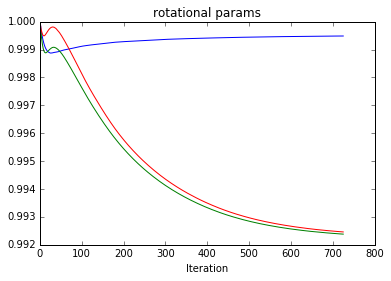

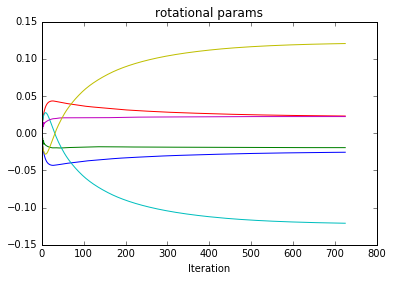

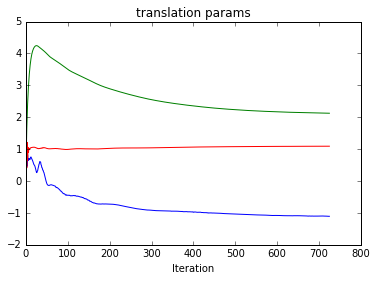

Best trial: 0
0.159046945704 0.159046261451
[[ 0.99947039 -0.02614304 -0.01937744 -1.08832626]
 [ 0.023638    0.99251393 -0.11982211  2.15736061]
 [ 0.02236489  0.11930061  0.99260625  1.08861868]]


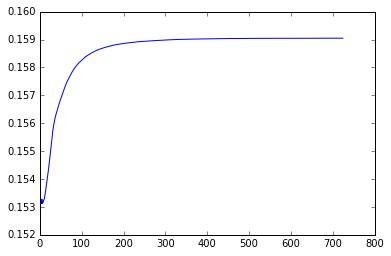

In [83]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

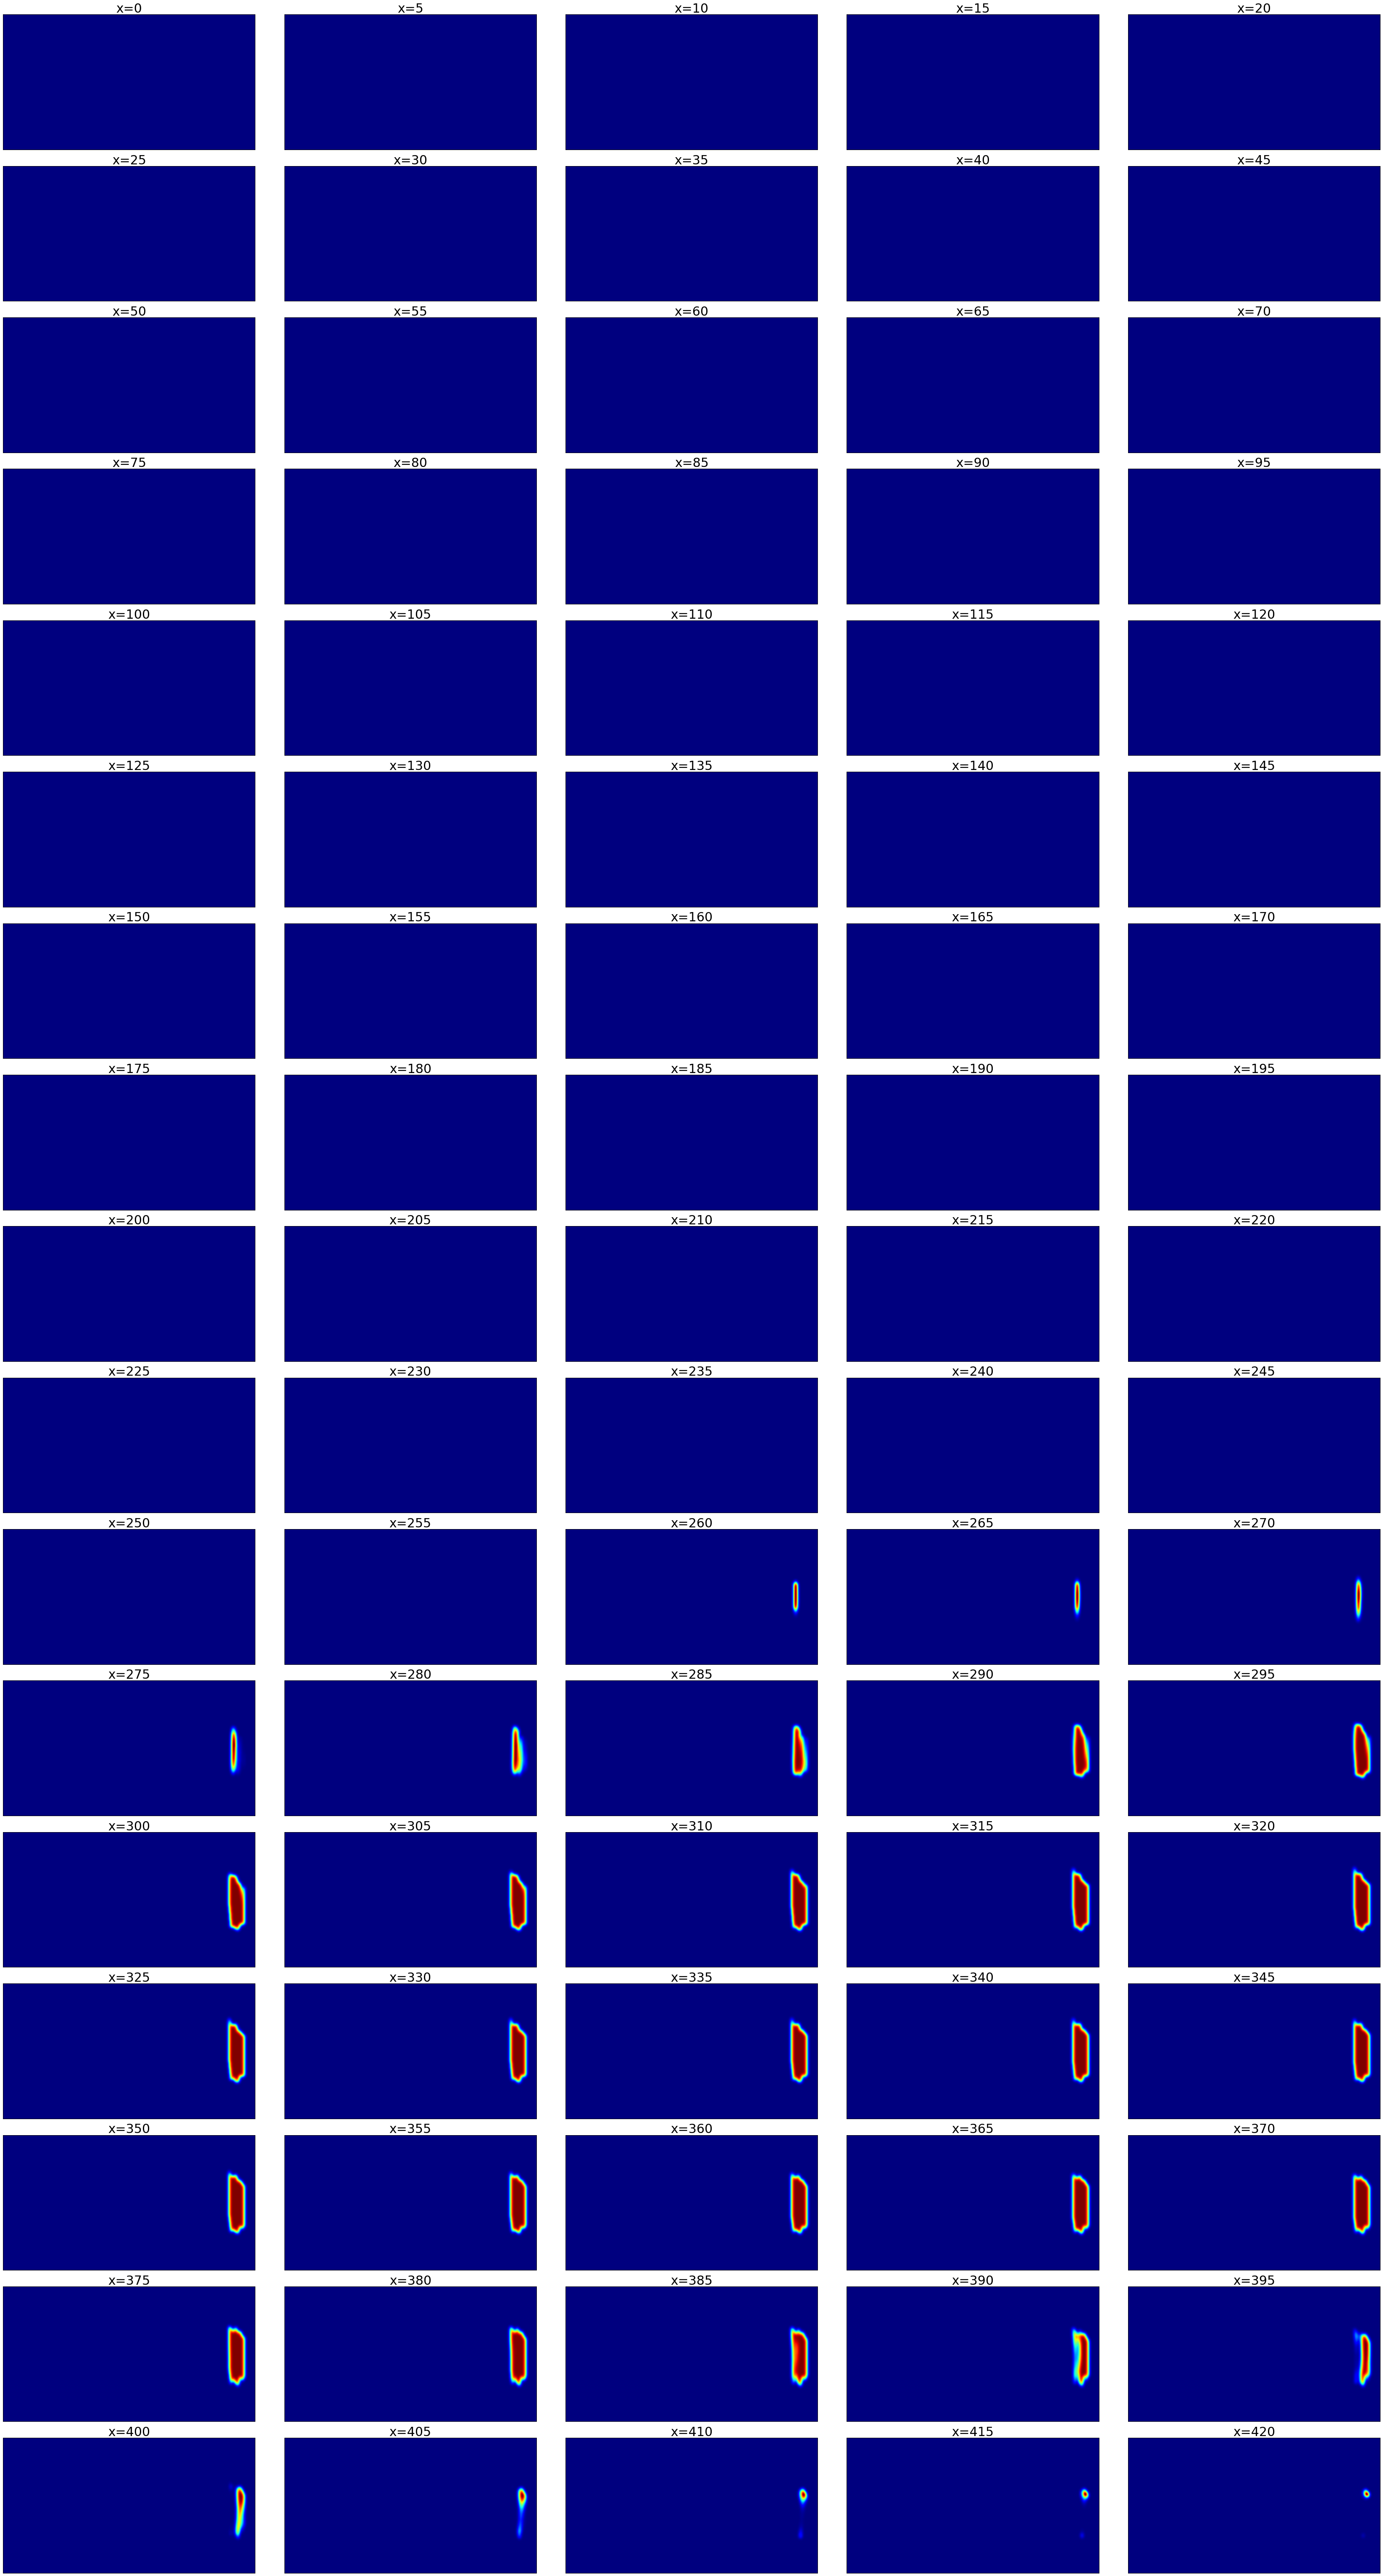

In [84]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [86]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving, warp_setting=24, 
                                      vol_type_f='annotationAsScore', vol_type_m='annotationAsScore')
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[ 1.11532859 -0.06692144  0.04421902 -2.73982271]
 [ 0.04702174  0.84888364 -0.01143821  1.16221123]
 [ 0.03235477 -0.14446589  0.86500497  8.63689425]
 [ 0.          0.          0.          1.        ]]


In [87]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [88]:
L = consolidate(params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)
print L

[[  9.99470388e-01  -2.61430370e-02  -1.93774408e-02   2.56439117e+02]
 [  2.36380016e-02   9.92513932e-01  -1.19822113e-01   8.00103513e+01]
 [  2.23648939e-02   1.19300610e-01   9.92606254e-01   4.03709582e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [91]:
Q_movingvol2fixedvol = np.dot(L, G_movingvol2fixedvol - np.column_stack([np.zeros((4,3)), 
                                                  np.r_[volume_moving_bbox_rel2fixedvol[[0,2,4]], 0]]))
print Q_movingvol2fixedvol

# This is shared by all structures.
fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, 
                                                                    volume_type='annotationAsScore', 
                                                                    structure='Sp5I_R',
                                      relative_to_uncropped=True)
print fixedvol_bbox_rel2fixedsubj

Q_movingvol2fixedsubj = Q_movingvol2fixedvol + np.column_stack([np.zeros((4,3)),
                                                                np.r_[fixedvol_bbox_rel2fixedsubj[[0,2,4]], 0]])
print Q_movingvol2fixedsubj

[[  1.11288166e+00  -8.62790170e-02   2.77330499e-02  -2.55170829e-01]
 [  6.91570576e-02   8.58257159e-01  -1.13954055e-01   3.93400267e+01]
 [  6.26694703e-02  -4.36221026e-02   8.58233707e-01  -8.54894081e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
rm -rf "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt" && mkdir -p "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt" "/home/yuncong/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_R_bbox.txt"
[1149 1757  492  737  -19  439]
[[  1.11288166e+00  -8.62790170e-02   2.77330499e-02   1.14874483e+03]
 [  6.91570576e-02   8.5

In [92]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving_in_bboxrel2fixedvol[structure_to_label_moving[structure]]

volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

print volume_m2fl_bbox_rel2fixedvol

(255, 426, 79, 179, 411, 438)


Interpolating/filling sparse volume: 0.03 seconds.


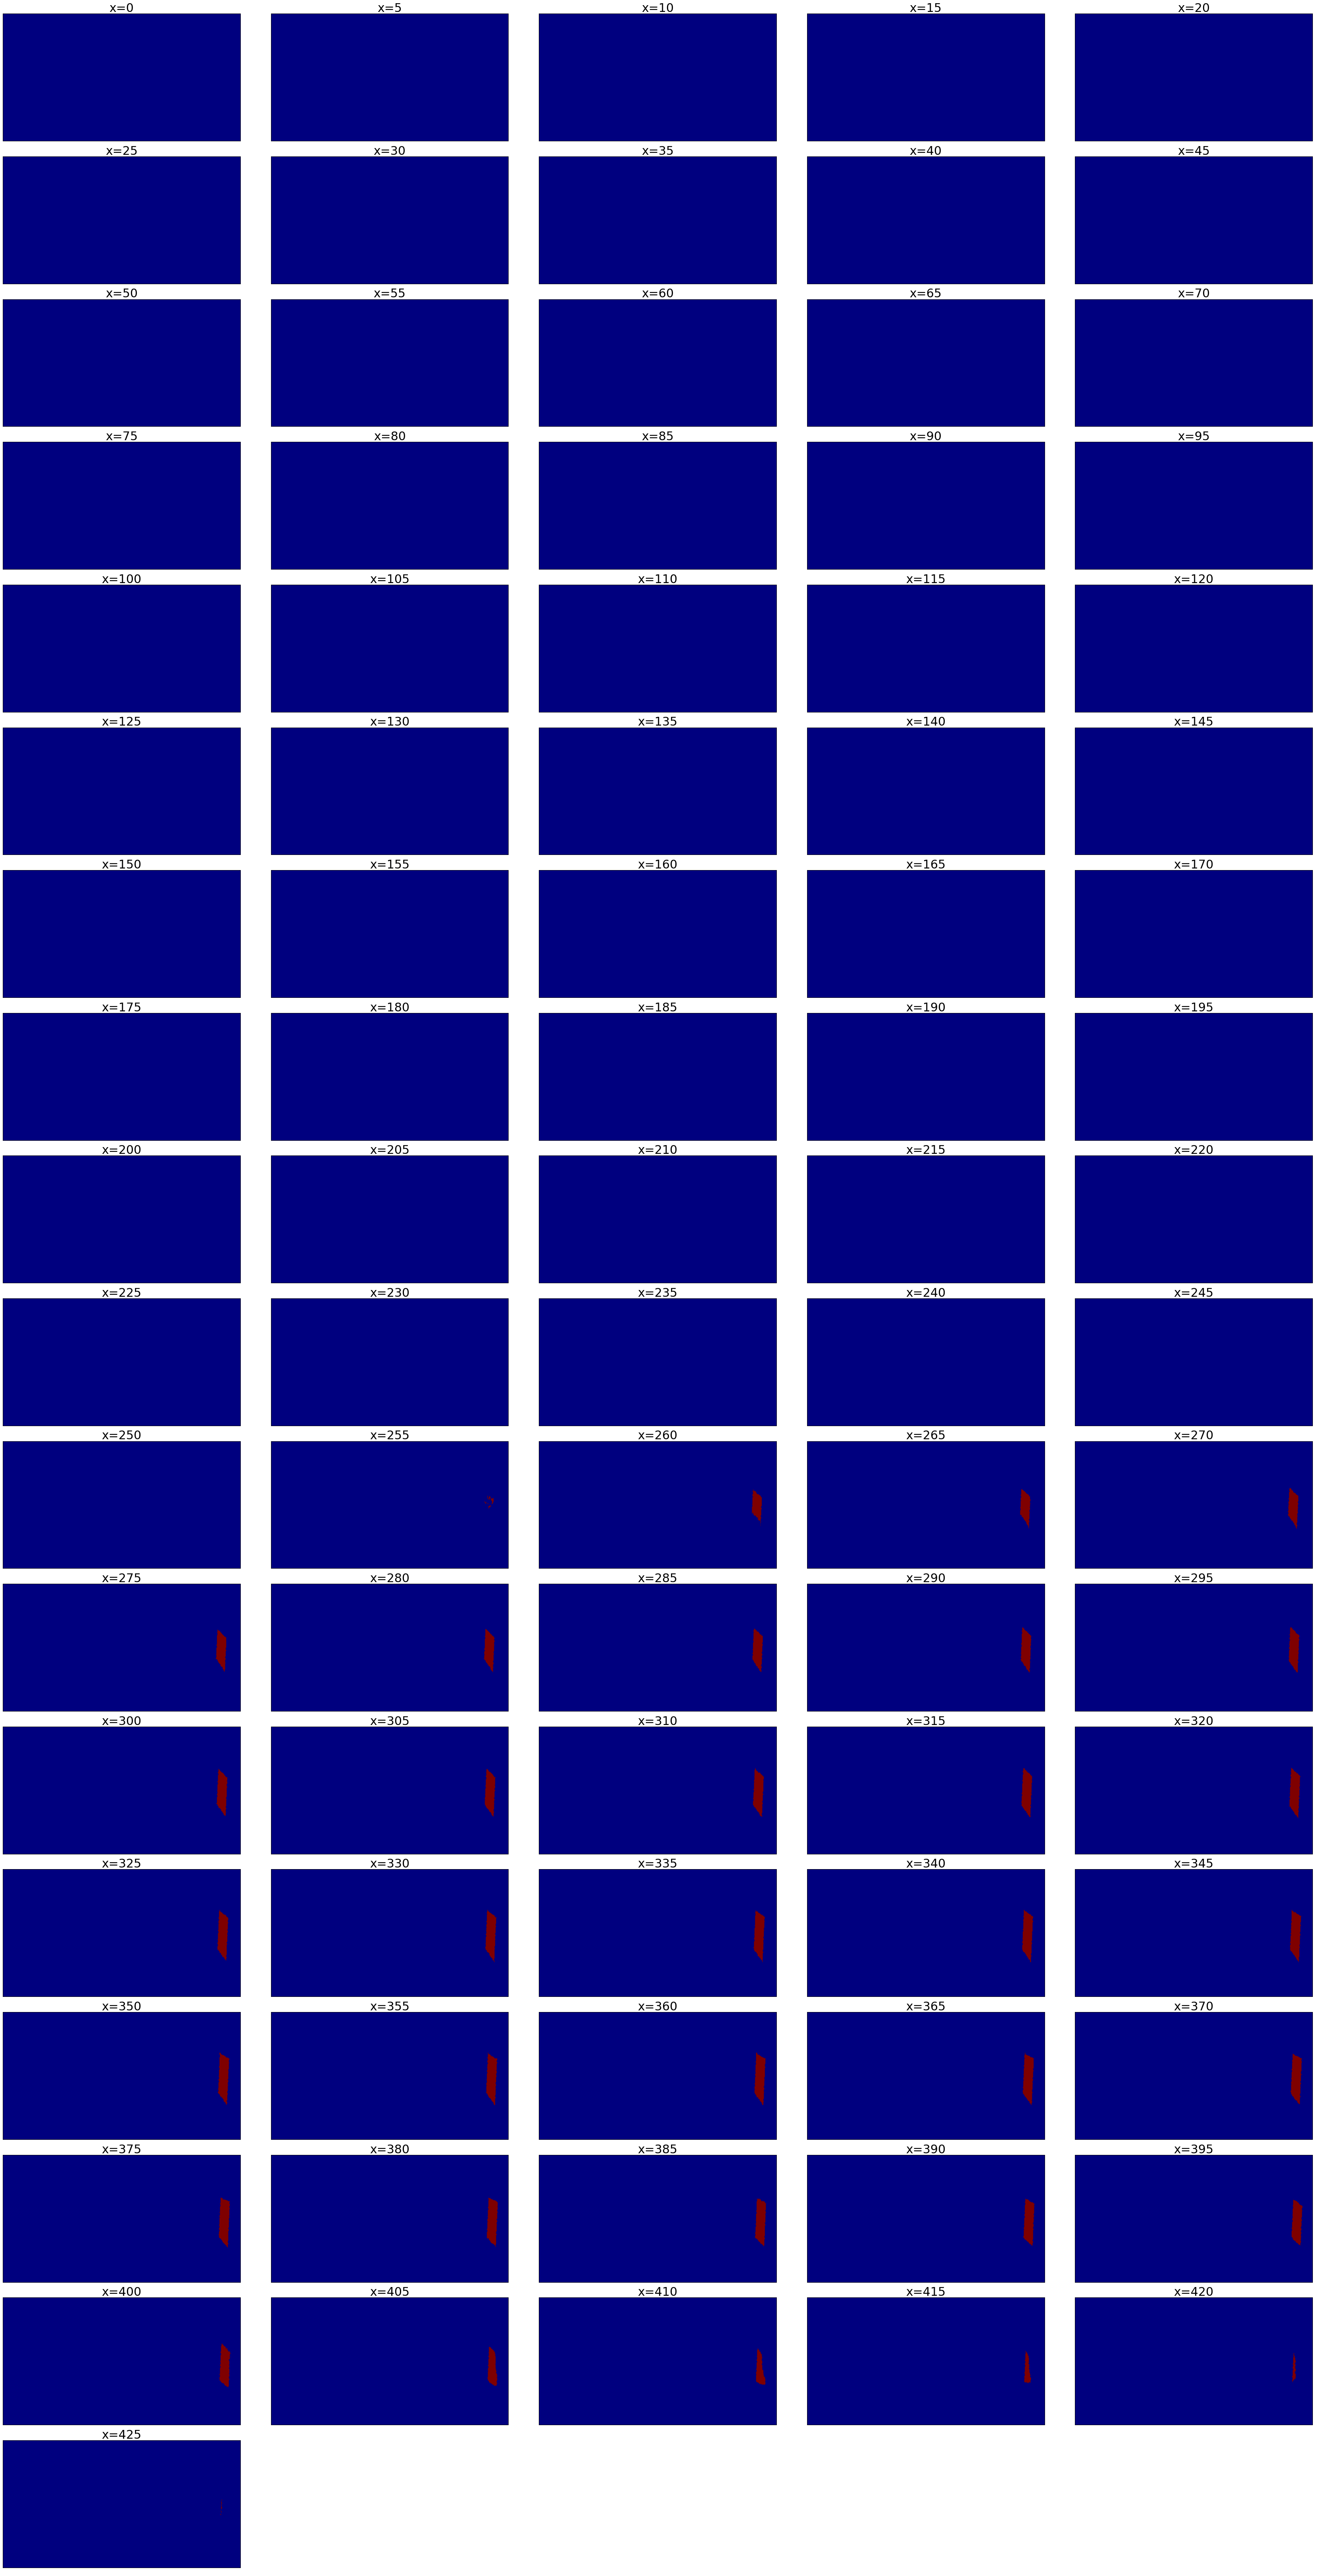

In [93]:
display_volume_sections(crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [95]:
# Warping all atlas structures.

volume_m2fl = {}
for label_m, vol_m in volume_moving_in_bboxrel2fixedvol.iteritems():
    
    volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
    transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fl[label_m] = crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

Interpolating/filling sparse volume: 0.03 seconds.


# Draw

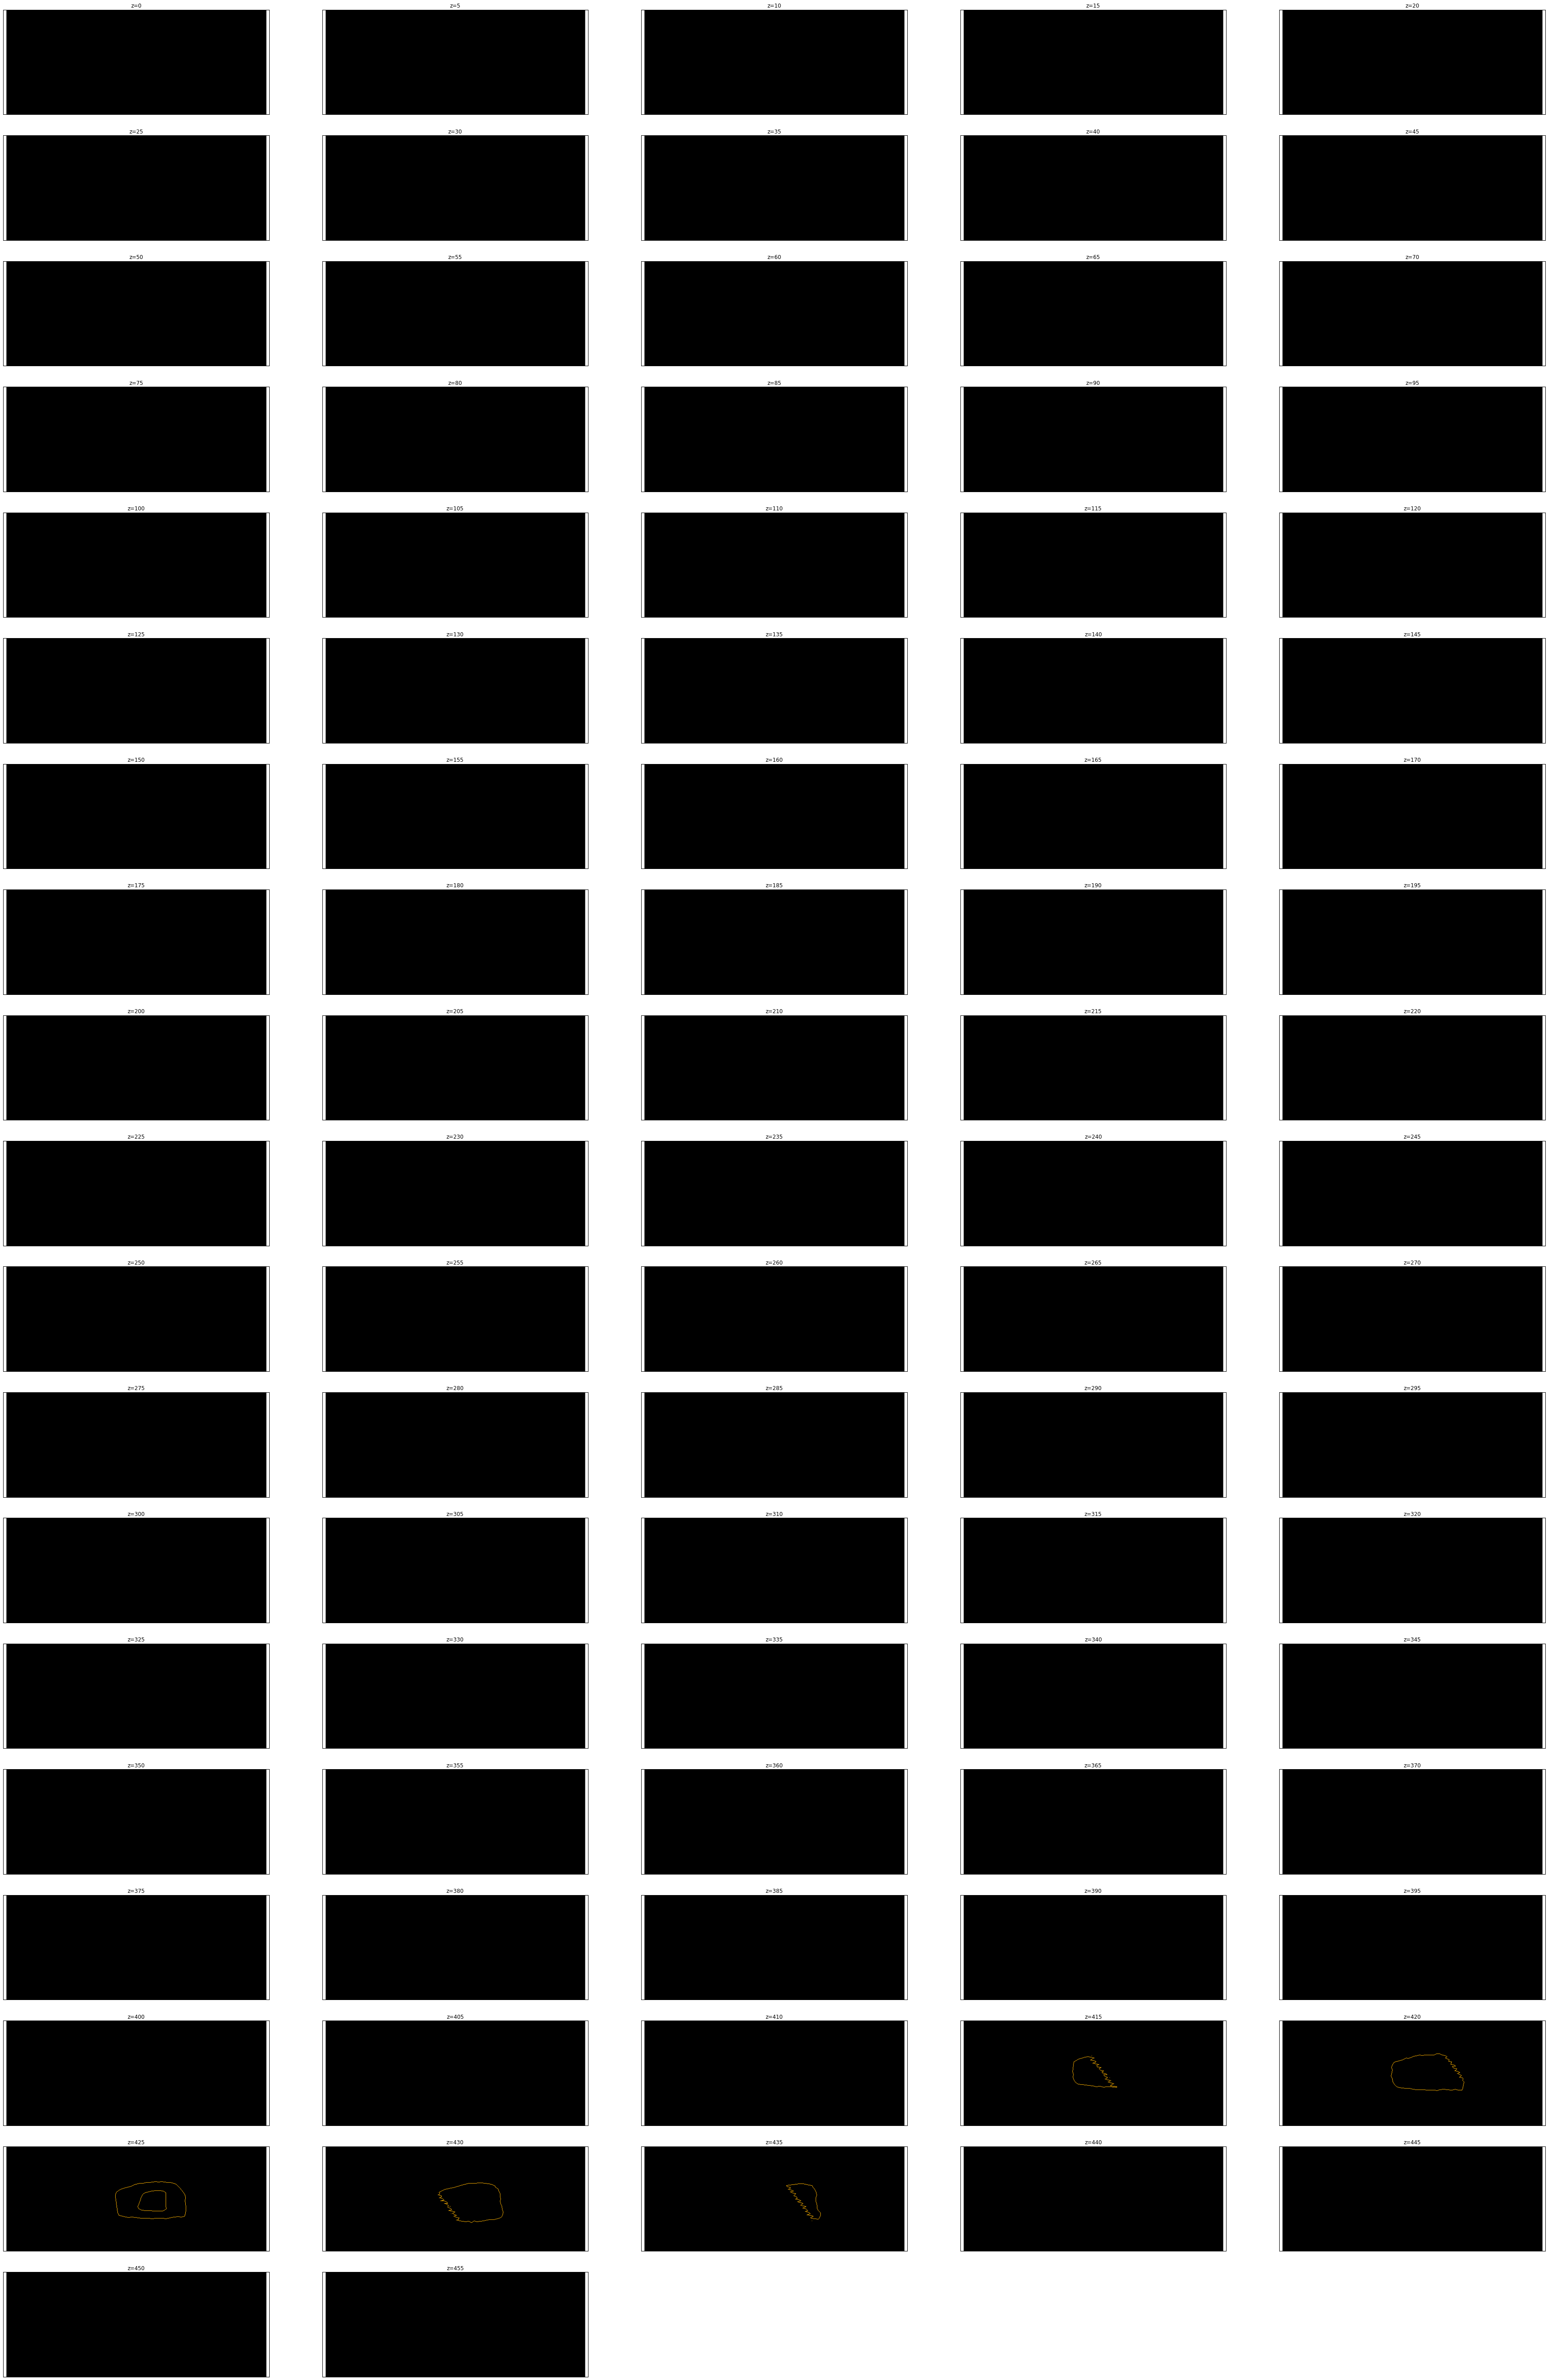

In [97]:
structures_to_draw = [l for l in volume_m2fl.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fl, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
#               markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

In [ ]:
for s in ['Sp5I_L', 'Sp5I_R',
                                                                 'LRt_L', 'LRt_R',
                                                                 '7N_L', '7N_R', 
                                                                 'Sp5C_L', 'Sp5C_R',
                                                                 '5N_L', '5N_R', 
                                                                 '7n_L', '7n_R', 
                                                                 'Sp5O_L', 'Sp5O_R']:
    structure = s
    
    try:
        t = time.time()

#         vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32, prep_id=2, detector_id=detector_id)
        vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32,
                                                volume_type='annotationAsScore')

        volume_m_warped_inbbox, volume_m_warped_bbox_rel2movingvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

        # Note: volume_m_warped_bbox_rel2movingvol is the same as volume_m_warped_bbox_rel2fixedvol.
        volume_m_warped_bbox_rel2fixedvol = volume_m_warped_bbox_rel2movingvol

        ######### Save volume ##########

        volume_m_warped_fp = \
        DataManager.get_transformed_volume_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    vol_type_m='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_fp)
        bp.pack_ndarray_file(volume_m_warped_inbbox, volume_m_warped_fp)
        upload_to_s3(volume_m_warped_fp)

        ############### bbox #############
        volume_m_warped_bbox_fp = \
        DataManager.get_transformed_volume_bbox_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                         vol_type_m='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_bbox_fp)
        np.savetxt(volume_m_warped_bbox_fp, volume_m_warped_bbox_rel2fixedvol)
        upload_to_s3(volume_m_warped_bbox_fp)

        sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t)) # 3s

    except Exception as e:
        sys.stderr.write('Error transforming volume %s: %s.\n' % (structure, e))

In [ ]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

In [11]:
import xml.etree.ElementTree as ET

def get_stacy_contours(stack):

#     xmlfile = '/shared/stacy_data/%s.xml' % stack
    xmlfile = '/home/yuncong/stacy_data/%s.xml' % stack
    download_from_s3(xmlfile)

    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()

    prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

    # neurolucida_name_map = \
    # {"Contour Name 1": 'RMC',
    # "Contour Name 2": '3N',
    # "Contour Name 3": 'fr',
    # 'Brain': 'outerContour',
    #  'SNR': 'SNR'}

    neurolucida_name_map = \
    {"IO": 'IO_L',
    "LRT": 'LRt_L',
    # "BRAINSTEM": 'brainstem',
    '5 MOTOR': '5N_L',
     '7n': '7n_L',
    'AMB MOTOR': 'Amb_L',
    'FACIAL MOTOR': '7N_L',
     'SpVC': 'Sp5C_L',
     'SpVO': 'Sp5O_L',
     'Sp5I': 'Sp5I_L',
     'Pr5': 'Pr5_L',
     'Sol': 'Sol_L',
     'Li': 'Li_L',
    #  'SpVIO': 'unknown',
    'R LrT': 'LRt_R',
    'R FN':  '7N_R',
    'R_7n': '7n_R',
    'R 5N':  '5N_R',
    'R SpVC': 'Sp5C_R',
    'R Sp5I': 'Sp5I_R',
    'R SpVO': 'Sp5O_R',
    'R Pr5':  'Pr5_R',
    'R IO':  'IO_R',
     'R-SpVI':  'Sp5I_R',
    'R-SpV':  'Sp5_R',
    'R-SpVO':  'Sp5O_R',
     'R-PrV':  'Pr5_R',
     'R-Amb':  'Amb_R',
    #  'R SpVIO':  'unknown',
     'SpVC_R':  'Sp5C_R',
     'R 5M':  '5N_R',
    #  'User Line 5':  'unknown',
    #  'NewContour': 'unknown',
    #   'User Line 2':  'unknown',
    }

    contours = defaultdict(list)

    for item in root.findall(prefix+'contour'):
        name = item.attrib['name']
        if name not in neurolucida_name_map:
    #         raise Exception('Name %s in stack %s not recognized' % (name, stack))
            sys.stderr.write('Name %s in stack %s not recognized. Ignored.\n' % (name, stack))
            continue
        name = neurolucida_name_map[name]
        curr_contour = []
    #     try:
    #         resolution = float(item.findall(prefix+'resolution')[0].text)
    #         print resolution
    #     except:
    #         pass
        for p in item.findall(prefix+'point'):
            curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        contours[name].append(np.array(curr_contour))

    contours.default_factory = None

    #################

    # structure_subset = ['3N_L', 'RMC_L', 'SNR_L']
    structure_subset = \
    [name for name in contours.keys() if parse_label(name)[0] in all_known_structures]
    print structure_subset

    ####################

    downscale = 32

    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':
        contours_orientationCorrected = {name_u: [cnt*[1,-1,1]
                                         for cnt in cnts3d if len(cnt) > 2] 
                               for name_u, cnts3d in contours.iteritems()}
    else:
        contours_orientationCorrected = {name_u: [cnt*[-1,-1,1]
                                         for cnt in cnts3d] 
                               for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                    for cnt in cnts3d] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()
                                                if name in structure_subset}

    
    #####################
    
    markers = defaultdict(list)
#     markers = {}

    for item in root.findall(prefix+'marker'):
        curr_markers = []
        for p in item.findall(prefix+'point'):
            curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        name = '7N_R'
        markers[name].append(np.array(curr_markers))
        
    markers = {name: np.concatenate(mkr_lists) for name, mkr_lists in markers.iteritems()}

    # markers.default_factory = None
    
    #########################
    
    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':

        markers_orientationCorrected = {name_u: mkrs3d*[1,-1,1]
                               for name_u, mkrs3d in markers.iteritems()}

    else:
        markers_orientationCorrected = {name_u: mkrs3d*[-1,-1,1]
                           for name_u, mkrs3d in markers.iteritems()}

    markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                           for name, mkrs3d in markers_orientationCorrected.iteritems()
                         if name in structure_subset}
    
    
    return contours_atlasResol, markers_atlasResol

In [4]:
stack_fixed = 'RV4_67hrs'
# stack_moving = 'RV14_65hrs'
# stack_moving = 'RV13_64hrs'
# stack_moving = 'RV19_61hrs'

stacks_to_colors = {'RV4_67hrs': (1,0,0), 'RV14_65hrs': (0,1,0), 'RV19_61hrs': (0,0,1), 'RV13_64hrs': (1,1,0)}

Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. I

['Sp5O_R', 'Sp5I_R', 'Sp5C_L', '7N_R', '5N_R', '5N_L', '7N_L', 'Sp5C_R', '7n_L', 'Amb_R', '7n_R', 'Amb_L', 'LRt_R', 'LRt_L']
[[ 1.11534825 -0.07524286  0.02318577 -1.77539378]
 [ 0.06689717  0.80876742 -0.01631299  4.08417546]
 [ 0.02639557 -0.10721925  0.88553802 -0.46894708]
 [ 0.          0.          0.          1.        ]]
rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL

File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp
Error loading volume for Sp5I_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters

File does not exist: /shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt
Error loading structure-specific transform for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R/RV14_65hrs_down32_annotationAsScoreVolume_Amb_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R_parameters.txt'.


rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV14_65hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not recognized. Ignored.
Name BRAINSTEM in stack RV13_64hrs not r

['LRt_R', 'Sp5O_R', 'Sp5C_L', 'Sp5I_L', '7N_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5I_R', 'Sp5C_R', '7n_R', 'Amb_L', 'LRt_L']
[[  1.08231686e+00  -1.28037567e-01   2.56404784e-02   1.44663392e+00]
 [  3.54973800e-02   1.04735856e+00  -2.09458349e-02  -2.99914673e+00]
 [  1.56415793e-02   1.04571170e-01   9.60718763e-01  -1.58829785e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsS

File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp
Error loading volume for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV13_64hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']


Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not recognized. Ignored.
Name BRAINSTEM in stack RV19_61hrs not r

['LRt_R', '7N_R', 'Sp5C_L', '7n_R', '5N_R', '5N_L', '7N_L', '7n_L', 'Sp5I_R', 'Sp5C_R', 'Amb_L', 'LRt_L']
[[  1.13142565e+00  -1.10682488e-01   4.05661194e-03  -2.91735602e-01]
 [  1.79845625e-02   1.09989262e+00   7.62957960e-04  -1.00592691e+01]
 [  3.86288713e-02  -1.67812243e-01   1.03764161e+00   9.58196473e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV

File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp
Error loading volume for 6N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp
Error loading volume for 6N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp
Error loading volume for Amb_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp
Error loading volume for LC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp
Error loading volume for LC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp
Error loading volume for Pn_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp
Error loading volume for Pn_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp
Error loading volume for Tz_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp
Error loading volume for Tz_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp
Error loading volume for VLL_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp
Error loading volume for VLL_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp
Error loading volume for RMC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp
Error loading volume for RMC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp
Error loading volume for SNC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp
Error loading volume for SNC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp
Error loading volume for SNR_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp
Error loading volume for SNR_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp
Error loading volume for 3N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp
Error loading volume for 3N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp
Error loading volume for 4N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp
Error loading volume for 4N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp
Error loading volume for Sp5I_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp
Error loading volume for Sp5O_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp
Error loading volume for Sp5O_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp
Error loading volume for PBG_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp
Error loading volume for PBG_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp
Error loading volume for 10N_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp
Error loading volume for 10N_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp
Error loading volume for VCA_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp
Error loading volume for VCA_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp
Error loading volume for VCP_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp
Error loading volume for VCP_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp
Error loading volume for DC_L: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp
Error loading volume for DC_R: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp
Error loading volume for AP: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp
Error loading volume for 12N: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp
Error loading volume for RtTg: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp
Error loading volume for SC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp
Error loading volume for IC: [Errno 2] No such file or directory: '/shared/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp20_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt" "/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters

File does not exist: /shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt
Error loading structure-specific transform for Amb_L: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L/RV19_61hrs_down32_annotationAsScoreVolume_Amb_L_warp17_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L_parameters.txt'.


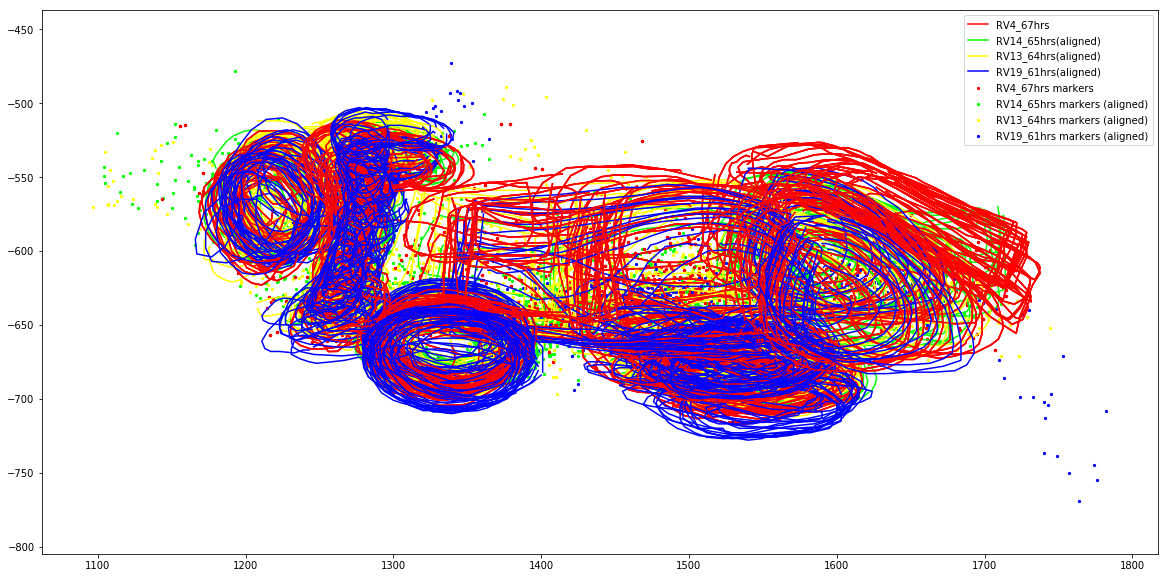

In [81]:
plt.figure(figsize=(20,10));

for stack_moving in ['RV14_65hrs', 'RV13_64hrs', 'RV19_61hrs']:
# for stack_moving in ['RV14_65hrs']:

    annvol_m_bbox_rel2world = DataManager.load_original_volume_bbox(stack=stack_moving, structure='7N_L', downscale=32, volume_type='annotationAsScore')
    annvol_f_bbox_rel2world = DataManager.load_original_volume_bbox(stack=stack_fixed, structure='7N_L', downscale=32, volume_type='annotationAsScore')

    contours_f_rel2world, markers_f_rel2world = get_stacy_contours(stack_fixed)
    contours_m_rel2world, markers_m_rel2world = get_stacy_contours(stack_moving)

    #############################

    global_params, cm_rel2ann, cf_rel2ann, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                        warp_setting=20, 
                                                             vol_type_m='annotationAsScore', 
                                                             vol_type_f='annotationAsScore', downscale=32)
    T_annvolm2annvolf = consolidate(global_params, cm_rel2ann, cf_rel2ann)
    print T_annvolm2annvolf

    ############################

    # L_annvolm2annvolf = {}
    # for structure in set(contours_m_rel2world.keys()) & set(contours_f_rel2world.keys()) :
    #     local_params, cm_rel2ann, cf_rel2ann, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
    #     DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
    #                                                         warp_setting=17, 
    #                                                              vol_type_m='annotationAsScore', 
    #                                                              vol_type_f='annotationAsScore', downscale=32,
    #                                          structure_m=structure,
    #                                          structure_f=structure)

    #     L_annvolm2annvolf[structure] = consolidate(local_params, cm_rel2ann, cf_rel2ann)

    #############################

    contours_m2fc_rel2world = {name_s: 
        [transform_points_affine([[1,0,0,0],[0,1,0,0],[0,0,1,0]], cnt_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m_rel2world in cnts_m_rel2world]
     for name_s, cnts_m_rel2world in contours_m_rel2world.iteritems()}

    ################################

    contours_m2fg_rel2world = {name_s: 
        [transform_points_affine(T_annvolm2annvolf[:3], cnt_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m_rel2world in cnts_m_rel2world]
     for name_s, cnts_m_rel2world in contours_m_rel2world.iteritems()}

    #######################

#     contours_m2fl_rel2world = {name_s: 
#             [transform_points_affine(L_annvolm2annvolf[name_s][:3], cnt_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
#             for cnt_m2fg_rel2world in cnts_m2fg_rel2world]
#          for name_s, cnts_m2fg_rel2world in contours_m2fg_rel2world.iteritems() 
#                                if name_s in L_annvolm2annvolf}

    #########################

    rigid_param_list, anchor_points, sigmas, weights = \
    get_weighted_average_rigid_parameters(stack_m=stack_moving, stack_f=stack_fixed, 
                                          structures=all_known_structures_sided,
                                         alpha=100.)

    contours_m2fwa_rel2world = {name_s: 
                                [transform_points_polyrigid(cnt_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]], 
                                    rigid_param_list.values(), 
                                    anchor_points.values(), 
                                    sigmas.values(), 
                                    weights.values()) + annvol_f_bbox_rel2world[[0,2,4]] 
        for cnt_m2fg_rel2world in cnts_m2fg_rel2world]
     for name_s, cnts_m2fg_rel2world in contours_m2fg_rel2world.iteritems()}


    ######################

    markers_m2fg_rel2world = {name_s: 
        transform_points_affine(T_annvolm2annvolf[:3], marker_m_rel2world - annvol_m_bbox_rel2world[[0,2,4]]) + annvol_f_bbox_rel2world[[0,2,4]] 
     for name_s, marker_m_rel2world in markers_m_rel2world.iteritems()}

    ######################

    markers_m2fwa_rel2world = {name_s: 
        transform_points_polyrigid(marker_m2fg_rel2world - annvol_f_bbox_rel2world[[0,2,4]], 
                                    rigid_param_list.values(), 
                                    anchor_points.values(), 
                                    sigmas.values(), 
                                    weights.values()) + annvol_f_bbox_rel2world[[0,2,4]] 
     for name_s, marker_m2fg_rel2world in markers_m2fg_rel2world.iteritems()}

    ######################

    for structure in contours_f_rel2world.keys():
    # for structure in ['7N_R']:

        if structure in contours_f_rel2world:
            for cnt_f in contours_f_rel2world[structure]:
                plt.plot(cnt_f[:,0], -cnt_f[:,1], c=stacks_to_colors[stack_fixed], label=stack_fixed);

        if structure in contours_m2fwa_rel2world:
            for cnt_m2f in contours_m2fwa_rel2world[structure]:
                plt.plot(cnt_m2f[:,0], -cnt_m2f[:,1], c=stacks_to_colors[stack_moving], 
#                          label=stack_moving+'(weighted average of structure-wise transforms)');
                         label=stack_moving+'(aligned)');

    #     if structure in contours_m2fc_rel2world:
    #         for cnt_m2f in contours_m2fc_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], cnt_m2f[:,1], c='c', label=stack_moving+'(bounding box origin aligned)');

    #     if structure in contours_m2fg_rel2world:
    #         for cnt_m2f in contours_m2fg_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], -cnt_m2f[:,1], c='b', label=stack_moving+'(global aligned)');

    #     if structure in contours_m2fl_rel2world:
    #         for cnt_m2f in contours_m2fl_rel2world[structure]:
    #             plt.plot(cnt_m2f[:,0], cnt_m2f[:,1], c='g', label=stack_moving+'(local)');

    plt.scatter(markers_f_rel2world['7N_R'][:,0], -markers_f_rel2world['7N_R'][:,1], c=stacks_to_colors[stack_fixed], 
                label=stack_fixed+' markers', s=5);
    plt.scatter(markers_m2fwa_rel2world['7N_R'][:,0], -markers_m2fwa_rel2world['7N_R'][:,1], c=stacks_to_colors[stack_moving], 
#                 label=stack_moving+' markers (weighted average of structure-wise transforms)', 
                label=stack_moving+' markers (aligned)', 
                s=5);
    # plt.scatter(markers_m2fg_rel2world['7N_R'][:,0], markers_m2fg_rel2world['7N_R'][:,1], c='b', 
    #             label=stack_moving+' markers (global aligned)', s=2);
    # plt.scatter(markers_m2fl_rel2world['7N_R'][:,0], markers_m2fl_rel2world['7N_R'][:,1], c='g', 
    #             label=stack_moving+' markers (local)', s=2);

# Merge labels
# https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels);

plt.axis('equal');

In [ ]:
structures_to_draw = [l for l in volume_m2fg.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fg, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

# Visualize weighted average transform

In [45]:
from utilities2015 import *

In [75]:
grid_xyzs_m2fwa_rel2annvolf_allz = {}
for z in range(0, annvol_f_bbox_rel2world[5]-annvol_f_bbox_rel2world[4], 50):
    grid_xyzs_m2fg_rel2annvolf = return_gridline_points_v2(annvol_f_bbox_rel2world[1]-annvol_f_bbox_rel2world[0],
                                                           annvol_f_bbox_rel2world[3]-annvol_f_bbox_rel2world[2],
                                                           20,z)

    grid_xyzs_m2fwa_rel2annvolf = transform_points_polyrigid(grid_xyzs_m2fg_rel2annvolf, 
                                        rigid_param_list.values(), 
                                        anchor_points.values(), 
                                        sigmas.values(), 
                                        weights.values()) 

    # plt.figure(figsize=(10, 10));
#     plt.scatter(grid_xyzs_m2fwa_rel2annvolf[:,0], grid_xyzs_m2fwa_rel2annvolf[:,1], s=1)
#     plt.title('Deformation field @ z=%d' % z)
#     plt.show()
    
    grid_xyzs_m2fwa_rel2annvolf_allz[z] = grid_xyzs_m2fwa_rel2annvolf

In [76]:
grid_xyzs_m2fwa_rel2annvolf = np.concatenate(grid_xyzs_m2fwa_rel2annvolf_allz.values())

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10));
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grid_xyzs_m2fwa_rel2annvolf[:,0], grid_xyzs_m2fwa_rel2annvolf[:,1], grid_xyzs_m2fwa_rel2annvolf[:,2], 
           color='k', marker='.', s=.1, alpha=.5)
ax.view_init(30, 45)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = plt.gca()
ax.grid(False)
plt.show()

In [212]:
fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                               vol_type_f='annotationAsScore',
                                               vol_type_m='annotationAsScore',
                                                  warp_setting=17,
                                               structure_m='5N_R',
                                               structure_f='5N_R',
                                               what='scoreHistory')
download_from_s3(fp, redownload=True)
scores = bp.unpack_ndarray_file(fp)

rm -rf "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp" && mkdir -p "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp" "/shared/CSHL_registration_parameters/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R/RV14_65hrs_down32_annotationAsScoreVolume_5N_R_warp17_RV4_67hrs_down32_annotationAsScoreVolume_5N_R_scoreHistory.bp"


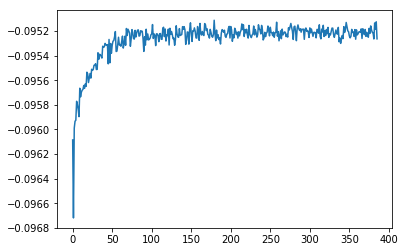

In [213]:
plt.plot(scores);